In [1]:
import json
import os
import random
import warnings
warnings.filterwarnings("ignore")
import os
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np

import pickle 
# os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'

In [2]:

#modelpath
model_path = "../models/Qwen2-0.5B"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
tokenizer=AutoTokenizer.from_pretrained(model_path,padding_side = "left")
model=AutoModelForCausalLM.from_pretrained(model_path).to(device)

# tokenizer=AutoTokenizer.from_pretrained("../Record/Qwen2-0.5B-Instruct")
# model=AutoModelForCausalLM.from_pretrained("../Record/Qwen2-0.5B-Instruct").to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
"""Prompts for mgsm."""
# pylint: disable=line-too-long

EXEMPLAR_NUMBER_ANSWERS = [11, 29, 39, 9, 33, 8, 8, 5]

EXEMPLAR_EQUATION_SOLUTIONS = [
    "5 + 6 = 11.",
    "4 * 5 = 20. 9 + 20 = 29.",
    "32 + 42 = 74. 74 - 35 = 39.",
    "5 + 2 = 7. 7 + 2 = 9.",
    "58 - 23 = 35. 35 - 2 = 33.",
    "5 * 3 = 15. 23 - 15 = 8.",
    "20 - 12 = 8.",
    "3 + 2 = 5.",
]

MGSM_EXEMPLARS = {
    "bn": {
        "1": {
            "q": "\u09aa\u09cd\u09b0\u09b6\u09cd\u09a8: "
                 "\u09b0\u099c\u09be\u09b0\u09c7\u09b0 5\u099f\u09bf "
                 "\u099f\u09c7\u09a8\u09bf\u09b8 \u09ac\u09b2 "
                 "\u0986\u099b\u09c7\u0964 \u09b8\u09c7 \u0986\u09b0\u0993 2 "
                 "\u0995\u09cd\u09af\u09be\u09a8 \u099f\u09c7\u09a8\u09bf\u09b8"
                 " \u09ac\u09b2 \u0995\u09bf\u09a8\u09c7\u099b\u09c7\u0964 "
                 "\u09aa\u09cd\u09b0\u09a4\u09bf\u099f\u09bf "
                 "\u0995\u09cd\u09af\u09be\u09a8\u09c7 3\u099f\u09bf "
                 "\u0995\u09b0\u09c7 \u099f\u09c7\u09a8\u09bf\u09b8 "
                 "\u09ac\u09b2 \u0986\u099b\u09c7\u0964 \u09a4\u09be\u09b0 "
                 "\u0995\u09be\u099b\u09c7 \u098f\u0996\u09a8 "
                 "\u0995\u09a4\u0997\u09c1\u09b2\u09bf "
                 "\u099f\u09c7\u09a8\u09bf\u09b8 \u09ac\u09b2 "
                 "\u0986\u099b\u09c7?",
            "a": "\u09a7\u09be\u09aa\u09c7 \u09a7\u09be\u09aa\u09c7 "
                 "\u0989\u09a4\u09cd\u09a4\u09b0: "
                 "\u09b0\u099c\u09be\u09b0\u09c7\u09b0 "
                 "\u09aa\u09cd\u09b0\u09a5\u09ae\u09c7 5\u099f\u09bf "
                 "\u09ac\u09b2 \u099b\u09bf\u09b2\u0964 2\u099f\u09bf "
                 "\u0995\u09cd\u09af\u09be\u09a8\u09c7\u09b0 "
                 "\u09aa\u09cd\u09b0\u09a4\u09bf\u099f\u09bf\u09a4\u09c7 "
                 "3\u099f\u09c7 \u099f\u09c7\u09a8\u09bf\u09b8 \u09ac\u09b2 "
                 "\u09ae\u09be\u09a8\u09c7 6\u099f\u09bf "
                 "\u099f\u09c7\u09a8\u09bf\u09b8 \u09ac\u09b2\u0964 5 + 6 = "
                 "11\u0964 \u0989\u09a4\u09cd\u09a4\u09b0 \u09b9\u09b2 11\u0964"
        },
        "2": {
            "q":
                "\u09aa\u09cd\u09b0\u09b6\u09cd\u09a8: "
                "\u09b8\u09be\u09b0\u09cd\u09ad\u09be\u09b0 "
                "\u0995\u0995\u09cd\u09b7\u09c7 \u09a8\u09df\u099f\u09bf "
                "\u0995\u09ae\u09cd\u09aa\u09bf\u0989\u099f\u09be\u09b0 "
                "\u099b\u09bf\u09b2\u0964 \u09b8\u09cb\u09ae\u09ac\u09be\u09b0"
                " \u09a5\u09c7\u0995\u09c7 "
                "\u09ac\u09c3\u09b9\u09b8\u09cd\u09aa\u09a4\u09bf\u09ac\u09be\u09b0"
                " \u09aa\u09cd\u09b0\u09a4\u09bf\u09a6\u09bf\u09a8 "
                "\u0986\u09b0\u0993 \u09aa\u09be\u0981\u099a\u099f\u09bf "
                "\u0995\u09b0\u09c7 "
                "\u0995\u09ae\u09cd\u09aa\u09bf\u0989\u099f\u09be\u09b0 "
                "\u09b8\u09cd\u09a5\u09be\u09aa\u09a8 \u0995\u09b0\u09be "
                "\u09b9\u09df\u09c7\u099b\u09bf\u09b2\u0964 "
                "\u09b8\u09be\u09b0\u09cd\u09ad\u09be\u09b0 "
                "\u0995\u0995\u09cd\u09b7\u09c7 \u098f\u0996\u09a8 "
                "\u0995\u09a4\u0997\u09c1\u09b2\u09bf "
                "\u0995\u09ae\u09cd\u09aa\u09bf\u0989\u099f\u09be\u09b0 "
                "\u0986\u099b\u09c7?",
            "a":
                "\u09a7\u09be\u09aa\u09c7 \u09a7\u09be\u09aa\u09c7 "
                "\u0989\u09a4\u09cd\u09a4\u09b0: "
                "\u09b8\u09cb\u09ae\u09ac\u09be\u09b0 \u09a5\u09c7\u0995\u09c7"
                " "
                "\u09ac\u09c3\u09b9\u09b8\u09cd\u09aa\u09a4\u09bf\u09ac\u09be\u09b0"
                " 4\u09a6\u09bf\u09a8 \u09b9\u09df\u0964 "
                "\u09aa\u09cd\u09b0\u09a4\u09bf\u09a6\u09bf\u09a8 "
                "5\u099f\u09bf \u0995\u09b0\u09c7 "
                "\u0995\u09ae\u09cd\u09aa\u09bf\u0989\u099f\u09be\u09b0 "
                "\u09af\u09cb\u0997 \u0995\u09b0\u09be "
                "\u09b9\u09df\u09c7\u099b\u09c7\u0964 \u09af\u09be\u09b0 "
                "\u0985\u09b0\u09cd\u09a5 \u09ae\u09cb\u099f 4 * 5 = "
                "20\u099f\u09bf "
                "\u0995\u09ae\u09cd\u09aa\u09bf\u0989\u099f\u09be\u09b0 "
                "\u09af\u09cb\u0997 \u0995\u09b0\u09be "
                "\u09b9\u09df\u09c7\u099b\u09c7\u0964 "
                "\u09b6\u09c1\u09b0\u09c1\u09a4\u09c7 9\u099f\u09bf "
                "\u0995\u09ae\u09cd\u09aa\u09bf\u0989\u099f\u09be\u09b0 "
                "\u099b\u09bf\u09b2, \u09a4\u09be\u0987 \u098f\u0996\u09a8 9 +"
                " 20 = 29\u099f\u09bf "
                "\u0995\u09ae\u09cd\u09aa\u09bf\u0989\u099f\u09be\u09b0 "
                "\u09b0\u09df\u09c7\u099b\u09c7\u0964 "
                "\u0989\u09a4\u09cd\u09a4\u09b0 \u09b9\u09b2 29\u0964"
        },
        "3": {
            "q": "\u09aa\u09cd\u09b0\u09b6\u09cd\u09a8: "
                 "\u09b2\u09bf\u09df\u09be\u09b0 32\u099f\u09bf "
                 "\u099a\u0995\u09cb\u09b2\u09c7\u099f \u099b\u09bf\u09b2 "
                 "\u098f\u09ac\u0982 \u09a4\u09be\u09b0 "
                 "\u09ac\u09cb\u09a8\u09c7\u09b0 \u099b\u09bf\u09b2 "
                 "42\u099f\u09bf\u0964 \u09af\u09a6\u09bf "
                 "\u09a4\u09be\u09b0\u09be 35\u099f\u09bf "
                 "\u0996\u09c7\u09df\u09c7 \u09a5\u09be\u0995\u09c7, "
                 "\u09a4\u09be\u09b9\u09b2\u09c7 \u09a4\u09be\u09a6\u09c7\u09b0"
                 " \u0995\u09be\u099b\u09c7 \u09ae\u09cb\u099f "
                 "\u0995\u09a4\u0997\u09c1\u09b2\u09bf "
                 "\u0985\u09ac\u09bf\u09b6\u09bf\u09b7\u09cd\u099f "
                 "\u0986\u099b\u09c7?",
            "a": "\u09a7\u09be\u09aa\u09c7 \u09a7\u09be\u09aa\u09c7 "
                 "\u0989\u09a4\u09cd\u09a4\u09b0: "
                 "\u09b2\u09bf\u09df\u09be\u09b0 32\u099f\u09bf "
                 "\u099a\u0995\u09cb\u09b2\u09c7\u099f \u099b\u09bf\u09b2 "
                 "\u098f\u09ac\u0982 \u09b2\u09bf\u09df\u09be\u09b0 "
                 "\u09ac\u09cb\u09a8\u09c7\u09b0 \u099b\u09bf\u09b2 "
                 "42\u099f\u09bf\u0964 \u09af\u09be\u09b0 "
                 "\u0985\u09b0\u09cd\u09a5 \u09b6\u09c1\u09b0\u09c1\u09a4\u09c7"
                 " 32 + 42 = 74\u099f\u09bf "
                 "\u099a\u0995\u09cb\u09b2\u09c7\u099f \u099b\u09bf\u09b2\u0964"
                 " 35\u099f\u09bf \u0996\u09be\u0993\u09df\u09be "
                 "\u09b9\u09df\u09c7 \u0997\u09c7\u099b\u09c7\u0964 "
                 "\u09a4\u09be\u0987 \u09a4\u09be\u09a6\u09c7\u09b0 "
                 "\u0995\u09be\u099b\u09c7 \u09ae\u09cb\u099f 74 - 35 = "
                 "39\u099f\u09bf \u099a\u0995\u09cb\u09b2\u099f "
                 "\u0986\u099b\u09c7\u0964 \u0989\u09a4\u09cd\u09a4\u09b0 "
                 "\u09b9\u09b2 39\u0964"
        },
        "4": {
            "q": "\u09aa\u09cd\u09b0\u09b6\u09cd\u09a8: "
                 "\u09b6\u09a8\u09c7\u09b0 \u09aa\u09be\u0981\u099a\u099f\u09bf"
                 " \u0996\u09c7\u09b2\u09a8\u09be \u0986\u099b\u09c7\u0964 "
                 "\u0995\u09cd\u09b0\u09bf\u09b8\u09ae\u09be\u09b8 "
                 "\u0989\u09aa\u09b2\u0995\u09cd\u09b7\u09c7 \u09b8\u09c7 "
                 "\u09a4\u09be\u09b0 \u09ae\u09be\u09a4\u09be \u0993 "
                 "\u09aa\u09bf\u09a4\u09be \u0989\u09ad\u09df\u09c7\u09b0 "
                 "\u09a5\u09c7\u0995\u09c7 \u09a6\u09c1\u099f\u09bf "
                 "\u0995\u09b0\u09c7 \u0996\u09c7\u09b2\u09a8\u09be "
                 "\u09aa\u09c7\u09df\u09c7\u099b\u09c7\u0964 \u09a4\u09be\u09b0"
                 " \u0995\u09be\u099b\u09c7 \u098f\u0996\u09a8 "
                 "\u0995\u09a4\u0997\u09c1\u09b2\u09bf "
                 "\u0996\u09c7\u09b2\u09a8\u09be \u0986\u099b\u09c7?",
            "a": "\u09a7\u09be\u09aa\u09c7 \u09a7\u09be\u09aa\u09c7 "
                 "\u0989\u09a4\u09cd\u09a4\u09b0: \u09a4\u09be\u09b0 "
                 "\u0995\u09be\u099b\u09c7 5\u099f\u09bf "
                 "\u0996\u09c7\u09b2\u09a8\u09be \u0986\u099b\u09c7\u0964 "
                 "\u09b8\u09c7 \u09a4\u09be\u09b0 "
                 "\u09ae\u09be\u09a4\u09be\u09b0 \u09a5\u09c7\u0995\u09c7 "
                 "2\u099f\u09bf \u0996\u09c7\u09b2\u09a8\u09be "
                 "\u09aa\u09c7\u09df\u09c7\u099b\u09bf\u09b2 "
                 "\u0985\u09a4\u098f\u09ac, \u098f\u09b0\u09aa\u09b0 "
                 "\u09a4\u09be\u09b0 5 + 2 = 7\u099f\u09bf "
                 "\u0996\u09c7\u09b2\u09a8\u09be "
                 "\u09b9\u09df\u09c7\u099b\u09c7\u0964 "
                 "\u09a4\u09be\u09b0\u09aa\u09b0 \u09b8\u09c7 "
                 "\u09a4\u09be\u09b0 \u09aa\u09bf\u09a4\u09be\u09b0 "
                 "\u09a5\u09c7\u0995\u09c7 2\u099f\u09bf "
                 "\u0996\u09c7\u09b2\u09a8\u09be "
                 "\u09aa\u09c7\u09df\u09c7\u099b\u09bf\u09b2, "
                 "\u09a4\u09be\u0987 \u09a4\u09be\u09b0 \u09ae\u09cb\u099f 7 + "
                 "2 = 9 \u099f\u09bf \u0996\u09c7\u09b2\u09a8\u09be "
                 "\u09b9\u09df\u09c7\u099b\u09c7\u0964 "
                 "\u0989\u09a4\u09cd\u09a4\u09b0 \u09b9\u09b2 9\u0964"
        },
        "5": {
            "q": "\u09aa\u09cd\u09b0\u09b6\u09cd\u09a8: "
                 "\u09ae\u09be\u0987\u0995\u09c7\u09b2\u09c7\u09b0 "
                 "58\u099f\u09bf \u0997\u09b2\u09ab \u09ac\u09b2 "
                 "\u099b\u09bf\u09b2\u0964 "
                 "\u09ae\u0999\u09cd\u0997\u09b2\u09ac\u09be\u09b0, "
                 "\u09b8\u09c7 23\u099f\u09bf \u0997\u09b2\u09ab \u09ac\u09b2 "
                 "\u09b9\u09be\u09b0\u09bf\u09df\u09c7\u099b\u09bf\u09b2\u0964 "
                 "\u09ac\u09c1\u09a7\u09ac\u09be\u09b0, \u09b8\u09c7 "
                 "\u0986\u09b0\u0993 2\u099f\u09bf \u09ac\u09b2 "
                 "\u09b9\u09be\u09b0\u09bf\u09df\u09c7\u099b\u09bf\u09b2\u0964 "
                 "\u09ac\u09c1\u09a7\u09ac\u09be\u09b0\u09c7\u09b0 "
                 "\u09b6\u09c7\u09b7\u09c7 \u09a4\u09be\u09b0 "
                 "\u0995\u09be\u099b\u09c7 \u0995\u09df\u099f\u09bf "
                 "\u0997\u09b2\u09ab \u09ac\u09b2 \u099b\u09bf\u09b2?",
            "a": "\u09a7\u09be\u09aa\u09c7 \u09a7\u09be\u09aa\u09c7 "
                 "\u0989\u09a4\u09cd\u09a4\u09b0: "
                 "\u09b6\u09c1\u09b0\u09c1\u09a4\u09c7 "
                 "\u09ae\u09be\u0987\u0995\u09c7\u09b2\u09c7\u09b0 "
                 "\u0995\u09be\u099b\u09c7 58\u099f\u09bf \u0997\u09b2\u09ab "
                 "\u09ac\u09b2 \u099b\u09bf\u09b2 \u098f\u09ac\u0982 "
                 "\u09b8\u09c7 23\u099f\u09bf \u09ac\u09b2 "
                 "\u09b9\u09be\u09b0\u09bf\u09df\u09c7\u099b\u09bf\u09b2, "
                 "\u09a4\u09be\u0987 \u09a4\u09be\u09b0 58 - 23 = "
                 "35\u099f\u09bf \u09ac\u09b2 \u0986\u099b\u09c7\u0964 "
                 "\u0986\u09b0\u0993 2\u099f\u09bf \u09ac\u09b2 "
                 "\u09b9\u09be\u09b0\u09be\u09a8\u09cb\u09b0 \u09aa\u09b0, "
                 "\u09a4\u09be\u09b0 \u098f\u0996\u09a8 35 - 2 = 33\u099f\u09bf"
                 " \u09ac\u09b2 \u0986\u099b\u09c7\u0964 "
                 "\u0989\u09a4\u09cd\u09a4\u09b0 \u09b9\u09b2 33\u0964"
        },
        "6": {
            "q": "\u09aa\u09cd\u09b0\u09b6\u09cd\u09a8: "
                 "\u0985\u09b2\u09bf\u09ad\u09bf\u09df\u09be\u09b0 $23 "
                 "\u0986\u099b\u09c7\u0964 \u09b8\u09c7 "
                 "\u09aa\u09be\u0981\u099a\u099f\u09bf "
                 "\u09ac\u09cd\u09af\u09be\u0997\u09c7\u09b2 "
                 "\u0995\u09bf\u09a8\u09c7\u099b\u09bf\u09b2 \u09af\u09be\u09b0"
                 " \u09aa\u09cd\u09b0\u09a4\u09bf\u099f\u09bf\u09b0 "
                 "\u09ae\u09c2\u09b2\u09cd\u09af $3\u0964 \u09a4\u09be\u09b0 "
                 "\u0995\u09be\u099b\u09c7 \u0995\u09a4 "
                 "\u0985\u09b0\u09cd\u09a5 "
                 "\u0985\u09ac\u09b6\u09bf\u09b7\u09cd\u099f "
                 "\u0986\u099b\u09c7?",
            "a": "\u09a7\u09be\u09aa\u09c7 \u09a7\u09be\u09aa\u09c7 "
                 "\u0989\u09a4\u09cd\u09a4\u09b0: "
                 "\u09aa\u09cd\u09b0\u09a4\u09bf\u099f\u09bf "
                 "\u09ac\u09cd\u09af\u09be\u0997\u09c7\u09b2\u09c7\u09b0 "
                 "\u09ae\u09c2\u09b2\u09cd\u09af $3 \u09b9\u09b2\u09c7 "
                 "5\u099f\u09bf "
                 "\u09ac\u09cd\u09af\u09be\u0997\u09c7\u09b2\u09c7\u09b0 "
                 "\u09ae\u09c2\u09b2\u09cd\u09af \u09b9\u0993\u09df\u09be "
                 "\u0989\u099a\u09bf\u09ce 5 *3 = 15 "
                 "\u09a1\u09b2\u09be\u09b0\u0964 "
                 "\u09b6\u09c1\u09b0\u09c1\u09a4\u09c7 "
                 "\u0985\u09b2\u09bf\u09ad\u09bf\u09df\u09be\u09b0 "
                 "\u0995\u09be\u099b\u09c7 $23 \u099b\u09bf\u09b2, "
                 "\u09a4\u09be\u0987 "
                 "\u09ac\u09b0\u09cd\u09a4\u09ae\u09be\u09a8\u09c7 "
                 "\u09a4\u09be\u09b0 \u0995\u09be\u099b\u09c7 23 - 15 = 8 "
                 "\u09a1\u09b2\u09be\u09b0 "
                 "\u0985\u09ac\u09b6\u09bf\u09b7\u09cd\u099f "
                 "\u0986\u099b\u09c7\u0964 \u0989\u09a4\u09cd\u09a4\u09b0 "
                 "\u09b9\u09b2 8\u0964"
        },
        "7": {
            "q": "\u09aa\u09cd\u09b0\u09b6\u09cd\u09a8: "
                 "\u099c\u09cd\u09af\u09be\u09b8\u09a8\u09c7\u09b0 "
                 "20\u099f\u09bf \u09b2\u09b2\u09bf\u09aa\u09aa "
                 "\u099b\u09bf\u09b2\u0964 \u09b8\u09c7 "
                 "\u09a1\u09c7\u09a8\u09bf\u0995\u09c7 \u0995\u09bf\u099b\u09c1"
                 " \u09b2\u09b2\u09bf\u09aa\u09aa "
                 "\u09a6\u09bf\u09df\u09c7\u099b\u09bf\u09b2\u0964 "
                 "\u09ac\u09b0\u09cd\u09a4\u09ae\u09be\u09a8\u09c7 "
                 "\u099c\u09cd\u09af\u09be\u09b8\u09a8\u09c7\u09b0 "
                 "\u0995\u09be\u099b\u09c7 12\u099f\u09bf "
                 "\u09b2\u09b2\u09bf\u09aa\u09aa \u0986\u099b\u09c7\u0964 "
                 "\u099c\u09cd\u09af\u09be\u09b8\u09a8 "
                 "\u09a1\u09c7\u09a8\u09bf\u0995\u09c7 "
                 "\u0995\u09a4\u0997\u09c1\u09b2\u09bf "
                 "\u09b2\u09b2\u09bf\u09aa\u09aa "
                 "\u09a6\u09bf\u09df\u09c7\u099b\u09bf\u09b2?",
            "a": "\u09a7\u09be\u09aa\u09c7 \u09a7\u09be\u09aa\u09c7 "
                 "\u0989\u09a4\u09cd\u09a4\u09b0: "
                 "\u099c\u09cd\u09af\u09be\u09b8\u09a8\u09c7\u09b0 "
                 "\u0995\u09be\u099b\u09c7 \u09aa\u09cd\u09b0\u09a5\u09ae\u09c7"
                 " 20\u099f\u09bf \u09b2\u09b2\u09bf\u09aa\u09aa "
                 "\u099b\u09bf\u09b2, \u0995\u09bf\u09a8\u09cd\u09a4\u09c1 "
                 "\u098f\u0996\u09a8 \u09a4\u09be\u09b0 "
                 "\u0995\u09be\u099b\u09c7 "
                 "\u09b6\u09c1\u09a7\u09c1\u09ae\u09be\u09a4\u09cd\u09b0 "
                 "12\u099f\u09bf \u0986\u099b\u09c7, "
                 "\u09a4\u09be\u09b9\u09b2\u09c7 \u09b8\u09c7 "
                 "\u09a1\u09c7\u09a8\u09bf\u0995\u09c7 20 - 12 = 8\u099f\u09bf "
                 "\u09b2\u09b2\u09bf\u09aa\u09aa "
                 "\u09a6\u09bf\u09df\u09c7\u099b\u09bf\u09b2\u0964 "
                 "\u0989\u09a4\u09cd\u09a4\u09b0 \u09b9\u09b2 8\u0964"
        },
        "8": {
            "q": "\u09aa\u09cd\u09b0\u09b6\u09cd\u09a8: "
                 "\u09aa\u09be\u09b0\u09cd\u0995\u09bf\u0982 \u09b2\u099f\u09c7"
                 " \u09af\u09a6\u09bf 3 \u099f\u09bf \u0997\u09be\u09dc\u09bf "
                 "\u09a5\u09be\u0995\u09c7 \u098f\u09ac\u0982 "
                 "\u0986\u09b0\u0993 2\u099f\u09bf \u0997\u09be\u09dc\u09bf "
                 "\u0986\u09b8\u09c7, \u09a4\u09be\u09b9\u09b2\u09c7 "
                 "\u09aa\u09be\u09b0\u09cd\u0995\u09bf\u0982 "
                 "\u09b2\u099f\u099f\u09bf\u09a4\u09c7 "
                 "\u0995\u09a4\u0997\u09c1\u09b2\u09bf \u0997\u09be\u09dc\u09bf"
                 " \u0986\u099b\u09c7?",
            "a": "\u09a7\u09be\u09aa\u09c7 \u09a7\u09be\u09aa\u09c7 "
                 "\u0989\u09a4\u09cd\u09a4\u09b0: "
                 "\u09b6\u09c1\u09b0\u09c1\u09a4\u09c7 "
                 "\u09b8\u09c7\u0996\u09be\u09a8\u09c7 3\u099f\u09bf "
                 "\u0997\u09be\u09dc\u09bf \u099b\u09bf\u09b2, "
                 "\u0986\u09b0\u0993 2\u099f\u09bf \u0997\u09be\u09dc\u09bf "
                 "\u0986\u09b8\u09c7, \u09a4\u09be\u09b9\u09b2\u09c7 "
                 "\u09ac\u09b0\u09cd\u09a4\u09ae\u09be\u09a8\u09c7 3 +2 = "
                 "5\u099f\u09bf \u0997\u09be\u09dc\u09bf "
                 "\u09a5\u09be\u0995\u09be \u0989\u099a\u09bf\u09ce\u0964 "
                 "\u0989\u09a4\u09cd\u09a4\u09b0 \u09b9\u09b2 5\u0964"
        }
    },
    "de": {
        "1": {
            "q": "Frage: Roger hat 5 Tennisb\u00e4lle. Er kauft noch 2 Dosen "
                 "Tennisb\u00e4lle. In jeder Dose sind 3 Tennisb\u00e4lle. Wie "
                 "viele Tennisb\u00e4lle hat er jetzt?",
            "a": "Schritt-f\u00fcr-Schritt-Antwort: Roger begann mit 5 "
                 "B\u00e4llen. 2 Dosen von jeweils 3 Tennisb\u00e4llen macht 6 "
                 "Tennisb\u00e4lle. 5 + 6 = 11. Die Antwort ist 11."
        },
        "2": {
            "q": "Frage: Es waren neun Computer im Serverraum. Von Montag bis "
                 "Donnerstag wurden jeden Tag noch f\u00fcnf Computer "
                 "installiert. Wie viele Computer sind jetzt im Serverraum?",
            "a": "Schritt-f\u00fcr-Schritt-Antwort: Von Montag bis Donnerstag "
                 "sind es 4 Tage. Jeden Tag kamen 5 neue Computer hinzu. Das "
                 "macht insgesamt 4 x 5 = 20 Computer, die hinzugef\u00fcgt "
                 "wurden. Am Anfang waren es 9 Computer, also sind es jetzt 9 +"
                 " 20 =29 Computer. Die Antwort lautet 29."
        },
        "3": {
            "q": "Frage: Leah hat 32 Pralinen und ihre Schwester hat 42. Wenn "
                 "sie 35 essen, wie viele sind dann insgesamt noch \u00fcbrig?",
            "a": "Schritt-f\u00fcr-Schritt-Antwort: Leah hat 32 Pralinen und "
                 "Leahs Schwester 42. Das bedeutet, dass es urspr\u00fcnglich "
                 "32 + 42 =74 Pralinen waren. 35 wurden gegessen. Also haben "
                 "sie insgesamt noch 74 - 35 = 39 Pralinen \u00fcbrig. Die "
                 "Antwort lautet 39."
        },
        "4": {
            "q": "Frage: Shawn hat f\u00fcnf Spielzeuge. Zu Weihnachten hat er "
                 "von seiner Mama und seinem Papa jeweils zwei Spielzeuge "
                 "bekommen. Wie viele Spielzeuge hat er jetzt?",
            "a": "Schritt-f\u00fcr-Schritt-Antwort: Er hat 5 Spielzeuge. Er hat"
                 " 2 von seiner Mama bekommen, sodass er nun 5 + 2 = 7 "
                 "Spielzeuge hat. Dann hat er noch 2 von seinem Papa bekommen, "
                 "also hat er insgesamt 7 + 2 = 9 Spielzeuge. Die Antwort "
                 "lautet 9."
        },
        "5": {
            "q": "Frage: Michael hat 58 Golfb\u00e4lle. Am Dienstag hat er 23 "
                 "Golfb\u00e4lle verloren. Am Mittwoch hat er 2 weitere "
                 "verloren. Wie viele Golfb\u00e4lle hat er Mittwoch am Ende "
                 "des Tages?",
            "a": "Schritt-f\u00fcr-Schritt-Antwort: Michael hatte anfangs 58 "
                 "Golfb\u00e4lle und hat 23 verloren, sodass er 58 - 23 = 35 "
                 "hat. Nachdem er 2 weitere verloren hat, hat er jetzt 35 - 2 ="
                 " 33 B\u00e4lle. Die Antwort lautet 33."
        },
        "6": {
            "q": "Frage: Olivia hat 23 US-Dollar. Sie hat f\u00fcnf Bagels "
                 "f\u00fcr 3 US-Dollar pro St\u00fcck gekauft. Wie viel Geld "
                 "hat sie \u00fcbrig?",
            "a": "Schritt-f\u00fcr-Schritt-Antwort: 5 Bagels f\u00fcr 3 "
                 "US-Dollar pro St\u00fcck kosten 5 x 3 = 15 Dollar. Olivia hat"
                 " anfangs 23 US-Dollar, also hat sie jetzt 23 - 15 = 8 Dollar "
                 "\u00fcbrig. Die Antwort lautet 8."
        },
        "7": {
            "q": "Frage: Jason hatte 20 Lutscher. Er hat Denny einige Lutscher "
                 "gegeben. Jetzt hat Jason 12 Lutscher. Wie viele Lutscher hat "
                 "Jason Denny gegeben?",
            "a": "Schritt-f\u00fcr-Schritt-Antwort: Jason hat mit 20 Lutschern "
                 "angefangen, aber jetzt hat er nur 12, also hat er Denny 20 - "
                 "12 = 8 Lutscher abgegeben. Die Antwort lautet 8."
        },
        "8": {
            "q": "Frage: Wenn 3 Autos auf dem Parkplatz stehen und 2 weitere "
                 "Autos ankommen, wie viele Autos stehen dann auf dem "
                 "Parkplatz?",
            "a": "Schritt-f\u00fcr-Schritt-Antwort: Anfangs sind 3 Autos da, 2 "
                 "weitere kommen an, also sind jetzt 3 + 2 = 5 Autos da. Die "
                 "Antwort lautet 5."
        }
    },
    "en": {
        "1": {
            "q": "Question: Roger has 5 tennis balls. He buys 2 more cans of "
                 "tennis balls. Each can has 3 tennis balls. How many tennis "
                 "balls does he have now?",
            "a": "Step-by-Step Answer: Roger started with 5 balls. 2 cans of 3 "
                 "tennis balls each is 6 tennis balls. 5 + 6 = 11. The answer "
                 "is 11.",
        },
        "2": {
            "q": "Question: There were nine computers in the server room. Five "
                 "more computers were installed each day, from monday to "
                 "thursday. How many computers are now in the server room?",
            "a": "Step-by-Step Answer: There are 4 days from monday to "
                 "thursday. 5 computers were added each day. That means in "
                 "total 4 * 5 = 20 computers were added. There were 9 computers"
                 " in the beginning, so now there are 9 + 20 = 29 computers. "
                 "The answer is 29.",
        },
        "3": {
            "q": "Question: Leah had 32 chocolates and her sister had 42. If "
                 "they ate 35, how many pieces do they have left in total?",
            "a": "Step-by-Step Answer: Leah had 32 chocolates and Leah’s sister"
                 " had 42. That means there were originally 32 + 42 = 74 "
                 "chocolates. 35 have been eaten. So in total they still have "
                 "74 - 35 = 39 chocolates. The answer is 39.",
        },
        "4": {
            "q": "Question: Shawn has five toys. For Christmas, he got two toys"
                 " each from his mom and dad. How many toys does he have now?",
            "a": "Step-by-Step Answer: He has 5 toys. He got 2 from mom, so "
                 "after that he has 5 + 2 = 7 toys. Then he got 2 more from "
                 "dad, so in total he has 7 + 2 = 9 toys. The answer is 9.",
        },
        "5": {
            "q": "Question: Michael had 58 golf balls. On tuesday, he lost 23 "
                 "golf balls. On wednesday, he lost 2 more. How many golf balls"
                 " did he have at the end of wednesday?",
            "a": "Step-by-Step Answer: Michael started with 58 golf balls and "
                 "lost 23, so he has 58 - 23 = 35. After he lost 2 more, he has"
                 " 35 - 2 = 33 balls now. The answer is 33.",
        },
        "6": {
            "q": "Question: Olivia has $23. She bought five bagels for $3 each."
                 " How much money does she have left?",
            "a": "Step-by-Step Answer: 5 bagels for $3 each should cost 5 * 3 ="
                 " 15 dollars. Olivia had $23 in the beginning, so now she has "
                 "23 - 15 = 8 dollars left. The answer is 8.",
        },
        "7": {
            "q": "Question: Jason had 20 lollipops. He gave Denny some "
                 "lollipops. Now Jason has 12 lollipops. How many lollipops did"
                 " Jason give to Denny?",
            "a": "Step-by-Step Answer: Jason started with 20 lollipops, but now"
                 " he only has 12, so he gave Denny 20 - 12 = 8 lollipops. The "
                 "answer is 8.",
        },
        "8": {
            "q": "Question: If there are 3 cars in the parking lot and 2 more "
                 "cars arrive, how many cars are in the parking lot?",
            "a": "Step-by-Step Answer: There are 3 cars in the beginning, 2 "
                 "more arrive, so now there should be 3 + 2 = 5 cars. The "
                 "answer is 5.",
        },
    },
    "es": {
        "1": {
            "q": "Pregunta: Roger tiene 5 pelotas de tenis. Compra 2 tubos "
                 "m\u00e1s de pelotas de tenis. Cada tubo contiene 3 pelotas de"
                 " tenis. \u00bfCu\u00e1ntas pelotas de tenis tiene ahora?",
            "a": "Respuesta paso a paso: Roger comenz\u00f3 con 5 pelotas. 2 "
                 "tubos de 3 pelotas de tenis cada uno equivale a 6 pelotas de "
                 "tenis. 5 + 6 = 11. La respuesta es 11."
        },
        "2": {
            "q": "Pregunta: Hab\u00eda nueve computadoras en la sala de "
                 "servidores. Se instalaron cinco computadoras cada d\u00eda, "
                 "de lunes a jueves. \u00bfCu\u00e1ntas computadoras hay ahora "
                 "en la sala de servidores?",
            "a": "Respuesta paso a paso: Hay 4 d\u00edas de lunes a jueves. Se "
                 "agregaron 5 computadoras cada d\u00eda. Eso significa que en "
                 "total se agregaron 4 * 5 = 20 computadoras. Al principio, "
                 "hab\u00eda 9 computadoras, por lo que ahora hay 9 + 20 = 29 "
                 "computadoras. La respuesta es 29."
        },
        "3": {
            "q": "Pregunta: Leah ten\u00eda 32 chocolates y su hermana "
                 "ten\u00eda 42. Si se comieron 35, \u00bfcu\u00e1ntos "
                 "chocolates les quedan en total?",
            "a": "Respuesta paso a paso: Leah ten\u00eda 32 chocolates y la "
                 "hermana de Leah ten\u00eda 42. Quiere decir que originalmente"
                 " hab\u00eda 32 + 42 = 74 chocolates. Se comieron 35. Por lo "
                 "tanto, en total todav\u00eda tienen 74 - 35 = 39 chocolates. "
                 "La respuesta es 39."
        },
        "4": {
            "q": "Pregunta: Shawn tiene cinco juguetes. Para Navidad, "
                 "recibi\u00f3 dos juguetes de su mam\u00e1 y dos de su "
                 "pap\u00e1. \u00bfCu\u00e1ntos juguetes tiene ahora?",
            "a": "Respuesta paso a paso: Tiene 5 juguetes. Recibi\u00f3 2 de la"
                 " mam\u00e1, por lo que despu\u00e9s de eso tiene 5 + 2 = 7 "
                 "juguetes. Luego, recibi\u00f3 2 m\u00e1s del pap\u00e1, "
                 "as\u00ed que en total tiene 7 + 2 = 9 juguetes. La respuesta "
                 "es 9."
        },
        "5": {
            "q": "Pregunta: Michael ten\u00eda 58 pelotas de golf. El martes, "
                 "perdi\u00f3 23 pelotas de golf. El mi\u00e9rcoles, "
                 "perdi\u00f3 2 m\u00e1s. \u00bfCu\u00e1ntas pelotas de golf "
                 "ten\u00eda al final del mi\u00e9rcoles?",
            "a": "Respuesta paso a paso: Michael comenz\u00f3 con 58 pelotas de"
                 " golf y perdi\u00f3 23, por lo tanto tiene 58 - 23 = 35. "
                 "Despu\u00e9s de perder 2 m\u00e1s, ahora tiene 35 - 2 = 33 "
                 "pelotas. La respuesta es 33."
        },
        "6": {
            "q": "Pregunta: Olivia tiene $23. Compr\u00f3 cinco roscas a $3 "
                 "cada una. \u00bfCu\u00e1nto dinero le queda?",
            "a": "Respuesta paso a paso: 5 roscas a $3 cada una deben costar 5 "
                 "* 3 = 15 d\u00f3lares. Olivia ten\u00eda $23 al principio, "
                 "por lo tanto ahora le quedan 23 - 15 = 8 d\u00f3lares. La "
                 "respuesta es 8."
        },
        "7": {
            "q": "Pregunta: Jason ten\u00eda 20 chupetines. Le dio algunos "
                 "chupetines a Denny. Ahora Jason tiene 12 chupetines. "
                 "\u00bfCu\u00e1ntos chupetines le dio Jason a Denny?",
            "a": "Respuesta paso a paso: Jason comenz\u00f3 con 20 chupetines, "
                 "pero ahora solo tiene 12, por lo tanto le dio a Denny 20 - 12"
                 " = 8 chupetines. La respuesta es 8."
        },
        "8": {
            "q": "Pregunta: Si hay 3 autos en el estacionamiento y llegan 2 "
                 "autos m\u00e1s, \u00bfcu\u00e1ntos autos hay en el "
                 "estacionamiento?",
            "a": "Respuesta paso a paso: Hay 3 autos al principio, llegan 2 "
                 "m\u00e1s, por lo tanto ahora debe haber 3 + 2 = 5 autos. La "
                 "respuesta es 5."
        }
    },
    "fr": {
        "1": {
            "q": "Question : Roger a 5 balles de tennis. Il ach\u00e8te 2 "
                 "autres bo\u00eetes de balles de tennis en plus. Si chaque "
                 "bo\u00eete contient 3 balles de tennis, combien de balles de "
                 "tennis a-t-il maintenant ?",
            "a": "R\u00e9ponse \u00e9tape par \u00e9tape : Roger a "
                 "commenc\u00e9 avec 5 balles. 2 bo\u00eetes de 3 balles de "
                 "tennis chacune repr\u00e9sentent 6 balles de tennis. 5 + 6 = "
                 "11. La r\u00e9ponse est 11."
        },
        "2": {
            "q": "Question : Il y avait neuf ordinateurs dans la salle des "
                 "serveurs. Cinq ordinateurs suppl\u00e9mentaires ont "
                 "\u00e9t\u00e9 install\u00e9s chaque jour, du lundi au jeudi. "
                 "Combien d'ordinateurs y a-t-il maintenant dans la salle des "
                 "serveurs ?",
            "a": "R\u00e9ponse \u00e9tape par \u00e9tape : De lundi \u00e0 "
                 "jeudi, il y a 4 jours. 5 ordinateurs ont \u00e9t\u00e9 "
                 "ajout\u00e9s par jour. Cela signifie qu'au total, 4 x 5 = 20 "
                 "ordinateurs ont \u00e9t\u00e9 ajout\u00e9s. Comme il y avait "
                 "9 ordinateurs au d\u00e9part, il y a maintenant 9 + 20 = 29 "
                 "ordinateurs. La r\u00e9ponse est 29."
        },
        "3": {
            "q": "Question : L\u00e9a avait 32 chocolats et sa s\u0153ur en "
                 "avait 42. Si elles en ont mang\u00e9 35, combien de morceaux "
                 "leur reste-t-il en tout ?",
            "a": "R\u00e9ponse \u00e9tape par \u00e9tape : L\u00e9a avait 32 "
                 "chocolats et sa s\u0153ur en avait 42. Cela signifie qu'il y "
                 "avait \u00e0 l'origine 32 + 42 = 74 chocolats. 35 chocolats "
                 "ont \u00e9t\u00e9 mang\u00e9s. Il leur en reste donc au total"
                 " 74 - 35 = 39 chocolats. La r\u00e9ponse est 39."
        },
        "4": {
            "q": "Question : Shawn a cinq jouets. Pour No\u00ebl, papa et maman"
                 " lui ont offert deux jouets chacun. Combien de jouets a-t-il "
                 "maintenant ?",
            "a": "R\u00e9ponse \u00e9tape par \u00e9tape : Il a 5 jouets. Il en"
                 " a re\u00e7u 2 de maman, ce qui fait qu'il a 5 + 2 = 7 "
                 "jouets. Ensuite, il a re\u00e7u 2 autres jouets de papa. Cela"
                 " fait donc un total de 7 + 2 = 9 jouets. La r\u00e9ponse est "
                 "9."
        },
        "5": {
            "q": "Question : Michael avait 58 balles de golf. Mardi, il a perdu"
                 " 23 balles de golf. Mercredi, il en a perdu 2 autres. De "
                 "combien de balles de golf disposait-il \u00e0 la fin du "
                 "mercredi ?",
            "a": "R\u00e9ponse \u00e9tape par \u00e9tape : Michael a "
                 "commenc\u00e9 avec 58 balles de golf et en a perdu 23. Il lui"
                 " reste donc 58 - 23 = 35. Apr\u00e8s en avoir perdu 2 autres,"
                 " il lui reste 35 - 2 = 33 balles. La r\u00e9ponse est 33."
        },
        "6": {
            "q": "Question : Olivia a 23 $. Elle a achet\u00e9 cinq bagels "
                 "\u00e0 3 $ chacun. Combien d'argent lui reste-t-il ?",
            "a": "R\u00e9ponse \u00e9tape par \u00e9tape : 5 bagels \u00e0 3 $ "
                 "chacun co\u00fbtent 5 x 3 = 15 dollars. Olivia avait 23 "
                 "dollars au d\u00e9part, il lui reste donc 23 - 15 = 8 "
                 "dollars. La r\u00e9ponse est 8."
        },
        "7": {
            "q": "Question : Jason avait 20 sucettes. Il en a donn\u00e9 \u00e0"
                 " Denny et il ne lui en reste plus que 12 \u00e0 pr\u00e9sent."
                 " Combien de sucettes Jason a-t-il donn\u00e9 \u00e0 Denny ?",
            "a": "R\u00e9ponse \u00e9tape par \u00e9tape : Au d\u00e9part, "
                 "Jason avait 20 sucettes. Il n'en a plus que 12, alors il a "
                 "donn\u00e9 \u00e0 Denny 20 - 12 = 8 sucettes. La r\u00e9ponse"
                 " est 8."
        },
        "8": {
            "q": "Question : S'il y a 3 voitures dans le parking et que 2 "
                 "autres arrivent, combien de voitures y a-t-il maintenant dans"
                 " le parking ?",
            "a": "R\u00e9ponse \u00e9tape par \u00e9tape : Au d\u00e9but, il y "
                 "a 3 voitures, puis 2 autres arrivent. \u00c7a fait donc 3 + 2"
                 " = 5 voitures. La r\u00e9ponse est 5."
        }
    },
    "ja": {
        "1": {
            "q":
                "\u554f\u984c\uff1a\u30ed\u30b8\u30e3\u30fc\u306f5\u500b\u306e\u30c6\u30cb\u30b9\u30dc\u30fc\u30eb\u304c\u3042\u308a\u307e\u3059\u3002\u30c6\u30cb\u30b9\u30dc\u30fc\u30eb\u306e\u7f36\u30922\u3064\u8ffd\u52a0\u3067\u8cb7\u3044\u307e\u3059\u3002\u305d\u308c\u305e\u308c\u306e\u7f36\u306b\u306f3\u3064\u306e\u30c6\u30cb\u30b9\u30dc\u30fc\u30eb\u304c\u5165\u3063\u3066\u3044\u307e\u3059\u3002\u5f7c\u306f\u4eca\u3044\u304f\u3064\u306e\u30c6\u30cb\u30b9\u30dc\u30fc\u30eb\u304c\u3042\u308a\u307e\u3059\u304b\uff1f",
            "a":
                "\u30b9\u30c6\u30c3\u30d7\u3054\u3068\u306e\u7b54\u3048\uff1a\u30ed\u30b8\u30e3\u30fc\u306f\u6700\u521d5\u500b\u306e\u30dc\u30fc\u30eb\u304c\u3042\u308a\u307e\u3057\u305f\u3002\u30c6\u30cb\u30b9\u30dc\u30fc\u30eb3\u500b\u5165\u308a\u306e\u7f36\u304c2\u3064\u3042\u308c\u3070\u3001\u30c6\u30cb\u30b9\u30dc\u30fc\u30eb\u306f6\u500b\u3042\u308a\u307e\u3059\u30025+6=11\u3002\u7b54\u3048\u306f11\u3067\u3059\u3002"
        },
        "2": {
            "q":
                "\u554f\u984c\uff1a\u30b5\u30fc\u30d0\u30fc\u30eb\u30fc\u30e0\u306b\u306f9\u53f0\u306e\u30b3\u30f3\u30d4\u30e5\u30fc\u30bf\u30fc\u304c\u3042\u308a\u307e\u3057\u305f\u3002\u6708\u66dc\u65e5\u304b\u3089\u6728\u66dc\u65e5\u307e\u3067\u6bce\u65e55\u53f0\u306e\u30b3\u30f3\u30d4\u30e5\u30fc\u30bf\u30fc\u3092\u30a4\u30f3\u30b9\u30c8\u30fc\u30eb\u3057\u307e\u3057\u305f\u3002\u4eca\u30b5\u30fc\u30d0\u30fc\u30eb\u30fc\u30e0\u306b\u306f\u96e3\u984c\u306e\u30b3\u30f3\u30d4\u30e5\u30fc\u30bf\u30fc\u304c\u3042\u308a\u307e\u3059\u304b\uff1f",
            "a":
                "\u30b9\u30c6\u30c3\u30d7\u3054\u3068\u306e\u7b54\u3048\uff1a\u6708\u66dc\u304b\u3089\u6728\u66dc\u307e\u30674\u65e5\u3042\u308a\u307e\u3059\u3002\u6bce\u65e55\u53f0\u306e\u30b3\u30f3\u30d4\u30e5\u30fc\u30bf\u30fc\u304c\u8ffd\u52a0\u3055\u308c\u307e\u3059\u3002\u3064\u307e\u308a\u3001\u5168\u90e8\u30674*5=20\u53f0\u306e\u30b3\u30f3\u30d4\u30e5\u30fc\u30bf\u30fc\u304c\u8ffd\u52a0\u3055\u308c\u307e\u3057\u305f\u3002\u6700\u521d\u306b9\u53f0\u306e\u30b3\u30f3\u30d4\u30e5\u30fc\u30bf\u30fc\u304c\u3042\u3063\u305f\u306e\u3067\u3001\u4eca\u306f9+20=29\u53f0\u306e\u30b3\u30f3\u30d4\u30e5\u30fc\u30bf\u30fc\u3068\u306a\u308a\u307e\u3059\u3002\u7b54\u3048\u306f29\u3067\u3059\u3002"
        },
        "3": {
            "q":
                "\u554f\u984c\uff1a\u30ea\u30a2\u306f32\u500b\u306e\u30c1\u30e7\u30b3\u30ec\u30fc\u30c8\u3092\u6301\u3063\u3066\u3044\u307e\u3057\u305f\u3001\u5f7c\u5973\u306e\u59b9\u306f42\u500b\u6301\u3063\u3066\u3044\u307e\u3057\u305f\u3002\u5f7c\u5973\u9054\u304c35\u500b\u98df\u3079\u305f\u3068\u3057\u305f\u3089\u3001\u5168\u90e8\u3067\u4f55\u500b\u6b8b\u3063\u3066\u3044\u307e\u3059\u304b\uff1f",
            "a":
                "\u30b9\u30c6\u30c3\u30d7\u3054\u3068\u306e\u7b54\u3048\uff1a\u30ea\u30a2\u306f32\u500b\u306e\u30c1\u30e7\u30b3\u30ec\u30fc\u30c8\u3092\u6301\u3063\u3066\u304a\u308a\u3001\u30ea\u30a2\u306e\u59b9\u306f42\u500b\u6301\u3063\u3066\u3044\u305f\u3002\u3064\u307e\u308a\u3001\u5143\u300532+42=74\u500b\u306e\u30c1\u30e7\u30b3\u30ec\u30fc\u30c8\u304c\u3042\u3063\u305f\u300235\u500b\u304c\u98df\u3079\u3089\u308c\u305f\u3002\u3060\u304b\u3089\u5168\u90e8\u3067\u3001\u5f7c\u5973\u305f\u3061\u306b\u306f74-35=39\u500b\u306e\u30c1\u30e7\u30b3\u30ec\u30fc\u30c8\u304c\u6b8b\u3063\u3066\u3044\u308b\u3002\u7b54\u3048\u306f39\u500b\u3002"
        },
        "4": {
            "q":
                "\u554f\u984c\uff1a\u30b7\u30e7\u30fc\u30f3\u306f5\u500b\u306e\u304a\u3082\u3061\u3083\u3092\u6301\u3063\u3066\u3044\u307e\u3059\u3002\u30af\u30ea\u30b9\u30de\u30b9\u306b\u3001\u5f7c\u306f\u7236\u3068\u6bcd\u304b\u3089\u305d\u308c\u305e\u308c2\u3064\u305a\u3064\u304a\u3082\u3061\u3083\u3092\u3082\u3089\u3044\u307e\u3057\u305f\u3002\u4eca\u5f7c\u306f\u3044\u304f\u3064\u306e\u304a\u3082\u3061\u3083\u304c\u3042\u308a\u307e\u3059\u304b\uff1f",
            "a":
                "\u30b9\u30c6\u30c3\u30d7\u3054\u3068\u306e\u7b54\u3048\uff1a\u5f7c\u306f5\u500b\u304a\u3082\u3061\u3083\u3092\u6301\u3063\u3066\u3044\u307e\u3059\u3002\u6bcd\u304b\u30892\u3064\u3082\u3089\u3063\u305f\u5f8c\u306f\u30015+2=7\u500b\u306e\u304a\u3082\u3061\u3083\u304c\u3042\u308a\u307e\u3059\u3002\u305d\u306e\u5f8c\u7236\u304b\u30892\u3064\u3055\u3089\u306b\u3082\u3089\u3044\u3001\u5168\u90e8\u3067\u5f7c\u306f\u30017+2=9\u500b\u306e\u304a\u3082\u3061\u3083\u304c\u3042\u308a\u307e\u3059\u3002\u7b54\u3048\u306f9\u500b\u3067\u3059\u3002"
        },
        "5": {
            "q":
                "\u554f\u984c\uff1a\u30de\u30a4\u30b1\u30eb\u306f58\u500b\u306e\u30b4\u30eb\u30d5\u30dc\u30fc\u30eb\u3092\u6301\u3063\u3066\u3044\u307e\u3059\u3002\u706b\u66dc\u65e5\u3001\u5f7c\u306f\n23\u500b\u306e\u30b4\u30eb\u30d5\u30dc\u30fc\u30eb\u3092\u5931\u304f\u3057\u307e\u3057\u305f\u3002\u6c34\u66dc\u65e5\u3001\u3055\u3089\u306b2\u500b\u5931\u304f\u3057\u307e\u3057\u305f\u3002\u6c34\u66dc\u65e5\u306e\u7d42\u308f\u308a\u306b\u306f\u3001\u5f7c\u306f\u4f55\u3053\u306e\u30b4\u30eb\u30d5\u30dc\u30fc\u30eb\u3092\u6301\u3063\u3066\u3044\u307e\u3057\u305f\u304b\uff1f",
            "a":
                "\u30b9\u30c6\u30c3\u30d7\u3054\u3068\u306e\u7b54\u3048\uff1a\u30de\u30a4\u30b1\u30eb\u306f\u6700\u521d58\u500b\u306e\u30b4\u30eb\u30d5\u30dc\u30fc\u30eb\u304c\u3042\u308a\u300123\u500b\u306a\u304f\u3057\u307e\u3057\u305f\u3001\u3060\u304b\u3089\u5f7c\u306f58-23=35\u500b\u6b8b\u3063\u3066\u3044\u307e\u3059\u3002\u5f7c\u304c\u3042\u30682\u500b\u306a\u304f\u3057\u305f\u5f8c\u3001\u5f7c\u306f\u4eca35-2=33\u500b\u6b8b\u3063\u3066\u3044\u307e\u3059\u3002\u7b54\u3048\u306f33\u500b\u3067\u3059\u3002"
        },
        "6": {
            "q":
                "\u554f\u984c\uff1a\u30aa\u30ea\u30d3\u30a2\u306b\u306f$23\u3042\u308a\u307e\u3059\u3002\u5f7c\u5973\u306f\u305d\u308c\u305e\u308c$3\u306e\u30d9\u30fc\u30b0\u30eb\u30925\u3064\u8cb7\u3044\u307e\u3057\u305f\u3002\u5f7c\u5973\u306b\u306f\u3044\u304f\u3089\u306e\u304a\u91d1\u304c\u6b8b\u3063\u3066\u3044\u307e\u3059\u304b\uff1f",
            "a":
                "\u30b9\u30c6\u30c3\u30d7\u3054\u3068\u306e\u7b54\u3048\uff1a$3\u306e\u30d9\u30fc\u30b0\u30eb\u306f5\u500b\u3067\u30015*3=15\u30c9\u30eb\u306b\u306a\u308b\u306f\u305a\u3067\u3059\u3002\u30aa\u30ea\u30d3\u30a2\u306f\u6700\u521d$23\u3042\u3063\u305f\u306e\u3067\u3001\u4eca\u5f7c\u5973\u306b\u306f23-15=8\u30c9\u30eb\u6b8b\u3063\u3066\u3044\u307e\u3059\u3002\u7b54\u3048\u306f8\u3067\u3059\u3002"
        },
        "7": {
            "q":
                "\u554f\u984c\uff1a\u30b8\u30a7\u30a4\u30bd\u30f3\u306f20\u500b\u306e\u98f4\u3092\u6301\u3063\u3066\u3044\u307e\u3059\u3002\u5f7c\u306f\u30c7\u30cb\u30fc\u306b\u98f4\u3092\u3044\u304f\u3064\u304b\u3042\u3052\u307e\u3057\u305f\u3002\u4eca\u3001\u30b8\u30a7\u30a4\u30bd\u30f3\u306b\u306f12\u500b\u306e\u98f4\u304c\u3042\u308a\u307e\u3059\u3002\u30b8\u30a7\u30a4\u30bd\u30f3\u306f\u30c7\u30cb\u30fc\u306b\u3044\u304f\u3064\u98f4\u3092\u3042\u3052\u307e\u3057\u305f\u304b\uff1f",
            "a":
                "\u30b9\u30c6\u30c3\u30d7\u3054\u3068\u306e\u7b54\u3048\uff1a\u30b8\u30a7\u30a4\u30bd\u30f3\u306b\u306f\u6700\u521d20\u500b\u306e\u98f4\u304c\u3042\u308a\u307e\u3057\u305f\u304c\u3001\u4eca\u5f7c\u306f12\u500b\u3057\u304b\u6301\u3063\u3066\u3044\u307e\u305b\u3093\u3001\u306a\u306e\u3067\u5f7c\u306f\u30c7\u30cb\u30fc\u306b\u300120-12=8\u500b\u306e\u98f4\u3092\u3042\u3052\u307e\u3057\u305f\u3002\u7b54\u3048\u306f8\u3067\u3059\u3002"
        },
        "8": {
            "q":
                "\u554f\u984c\uff1a\u99d0\u8eca\u5834\u306b3\u53f0\u306e\u8eca\u304c\u3042\u308a\u30012\u53f0\u306e\u8eca\u304c\u5230\u7740\u3059\u308b\u3068\u3057\u305f\u3089\u3001\u99d0\u8eca\u5834\u306b\u306f\u4f55\u53f0\u306e\u8eca\u304c\u3042\u308a\u307e\u3059\u304b\uff1f",
            "a":
                "\u30b9\u30c6\u30c3\u30d7\u3054\u3068\u306e\u7b54\u3048\uff1a\u6700\u521d\u306b3\u53f0\u306e\u8eca\u304c\u3042\u308a\u3001\u3055\u3089\u306b2\u53f0\u5230\u7740\u3057\u305f\u306e\u3067\u3001\u4eca\u306f3+2\u30675\u53f0\u306e\u8eca\u304c\u3042\u308b\u306f\u305a\u3067\u3059\u3002\u7b54\u3048\u306f5\u3067\u3059\u3002"
        }
    },
    "ru": {
        "1": {
            "q": "\u0417\u0430\u0434\u0430\u0447\u0430: \u0443 "
                 "\u0420\u043e\u0434\u0436\u0435\u0440\u0430 5 "
                 "\u0442\u0435\u043d\u043d\u0438\u0441\u043d\u044b\u0445 "
                 "\u043c\u044f\u0447\u0435\u0439. \u041e\u043d "
                 "\u043f\u043e\u043a\u0443\u043f\u0430\u0435\u0442 "
                 "\u0435\u0449\u0435 2 \u0431\u0430\u043d\u043a\u0438 "
                 "\u0442\u0435\u043d\u043d\u0438\u0441\u043d\u044b\u0445 "
                 "\u043c\u044f\u0447\u0435\u0439. \u0412 "
                 "\u043a\u0430\u0436\u0434\u043e\u0439 "
                 "\u0431\u0430\u043d\u043a\u0435 3 "
                 "\u0442\u0435\u043d\u043d\u0438\u0441\u043d\u044b\u0445 "
                 "\u043c\u044f\u0447\u0430. "
                 "\u0421\u043a\u043e\u043b\u044c\u043a\u043e "
                 "\u0442\u0435\u043d\u043d\u0438\u0441\u043d\u044b\u0445 "
                 "\u043c\u044f\u0447\u0435\u0439 \u0443 "
                 "\u043d\u0435\u0433\u043e "
                 "\u0441\u0435\u0439\u0447\u0430\u0441?",
            "a": "\u041f\u043e\u0448\u0430\u0433\u043e\u0432\u043e\u0435 "
                 "\u0440\u0435\u0448\u0435\u043d\u0438\u0435: \u0432 "
                 "\u043d\u0430\u0447\u0430\u043b\u0435 \u0443 "
                 "\u0420\u043e\u0434\u0436\u0435\u0440\u0430 "
                 "\u0431\u044b\u043b\u043e 5 \u043c\u044f\u0447\u0435\u0439. 2 "
                 "\u0431\u0430\u043d\u043a\u0438 \u043f\u043e 3 "
                 "\u0442\u0435\u043d\u043d\u0438\u0441\u043d\u044b\u0445 "
                 "\u043c\u044f\u0447\u0430 \u043a\u0430\u0436\u0434\u0430\u044f"
                 " \u2014 \u044d\u0442\u043e 6 "
                 "\u0442\u0435\u043d\u043d\u0438\u0441\u043d\u044b\u0445 "
                 "\u043c\u044f\u0447\u0435\u0439. 5 + 6 = 11. "
                 "\u041e\u0442\u0432\u0435\u0442 \u2014 11."
        },
        "2": {
            "q":
                "\u0417\u0430\u0434\u0430\u0447\u0430: \u0432 "
                "\u0441\u0435\u0440\u0432\u0435\u0440\u043d\u043e\u0439 "
                "\u0431\u044b\u043b\u043e \u0434\u0435\u0432\u044f\u0442\u044c"
                " "
                "\u043a\u043e\u043c\u043f\u044c\u044e\u0442\u0435\u0440\u043e\u0432."
                " \u041a\u0430\u0436\u0434\u044b\u0439 "
                "\u0434\u0435\u043d\u044c \u0441 "
                "\u043f\u043e\u043d\u0435\u0434\u0435\u043b\u044c\u043d\u0438\u043a\u0430"
                " \u043f\u043e \u0447\u0435\u0442\u0432\u0435\u0440\u0433 "
                "\u0443\u0441\u0442\u0430\u043d\u0430\u0432\u043b\u0438\u0432\u0430\u043b\u043e\u0441\u044c"
                " \u0435\u0449\u0435 \u043f\u043e \u043f\u044f\u0442\u044c "
                "\u043a\u043e\u043c\u043f\u044c\u044e\u0442\u0435\u0440\u043e\u0432."
                " \u0421\u043a\u043e\u043b\u044c\u043a\u043e "
                "\u043a\u043e\u043c\u043f\u044c\u044e\u0442\u0435\u0440\u043e\u0432"
                " \u0441\u0435\u0439\u0447\u0430\u0441 \u0432 "
                "\u0441\u0435\u0440\u0432\u0435\u0440\u043d\u043e\u0439?"
                "\u043a\u043e\u043c\u043f\u044c\u044e\u0442\u0435\u0440\u043e\u0432.",
            "a":
                "\u041f\u043e\u0448\u0430\u0433\u043e\u0432\u043e\u0435 "
                "\u0440\u0435\u0448\u0435\u043d\u0438\u0435: \u0441 "
                "\u043f\u043e\u043d\u0435\u0434\u0435\u043b\u044c\u043d\u0438\u043a\u0430"
                " \u043f\u043e \u0447\u0435\u0442\u0432\u0435\u0440\u0433 "
                "\u043f\u0440\u043e\u0448\u043b\u043e 4 \u0434\u043d\u044f. "
                "\u041a\u0430\u0436\u0434\u044b\u0439 \u0434\u0435\u043d\u044c"
                " \u0434\u043e\u0431\u0430\u0432\u043b\u044f\u043b\u0438 "
                "\u043f\u043e 5 "
                "\u043a\u043e\u043c\u043f\u044c\u044e\u0442\u0435\u0440\u043e\u0432."
                " \u0422\u043e \u0435\u0441\u0442\u044c "
                "\u0432\u0441\u0435\u0433\u043e "
                "\u0434\u043e\u0431\u0430\u0432\u0438\u043b\u0438 4 * 5 = 20 "
                "\u043a\u043e\u043c\u043f\u044c\u044e\u0442\u0435\u0440\u043e\u0432."
                " \u0412\u043d\u0430\u0447\u0430\u043b\u0435 "
                "\u0431\u044b\u043b\u043e 9 "
                "\u043a\u043e\u043c\u043f\u044c\u044e\u0442\u0435\u0440\u043e\u0432,"
                " \u0437\u043d\u0430\u0447\u0438\u0442, "
                "\u0442\u0435\u043f\u0435\u0440\u044c "
                "\u0441\u0442\u0430\u043b\u043e 9 + 20 = 29 "
                "\u043a\u043e\u043c\u043f\u044c\u044e\u0442\u0435\u0440\u043e\u0432."
                " \u041e\u0442\u0432\u0435\u0442 \u2014 29."
        },
        "3": {
            "q": "\u0417\u0430\u0434\u0430\u0447\u0430: \u0443 "
                 "\u041b\u0438\u0438 \u0431\u044b\u043b\u043e 32 "
                 "\u0448\u043e\u043a\u043e\u043b\u0430\u0434\u043d\u044b\u0445 "
                 "\u043a\u043e\u043d\u0444\u0435\u0442\u044b, \u0430 \u0443 "
                 "\u0435\u0435 \u0441\u0435\u0441\u0442\u0440\u044b \u2014 42. "
                 "\u0415\u0441\u043b\u0438 35 \u043e\u043d\u0438 "
                 "\u0441\u044a\u0435\u043b\u0438, "
                 "\u0441\u043a\u043e\u043b\u044c\u043a\u043e "
                 "\u0432\u0441\u0435\u0433\u043e \u0448\u0442\u0443\u043a "
                 "\u0443 \u043d\u0438\u0445 "
                 "\u043e\u0441\u0442\u0430\u043b\u043e\u0441\u044c?",
            "a":
                "\u041f\u043e\u0448\u0430\u0433\u043e\u0432\u043e\u0435 "
                "\u0440\u0435\u0448\u0435\u043d\u0438\u0435: \u0443 "
                "\u041b\u0438\u0438 \u0431\u044b\u043b\u043e 32 "
                "\u0448\u043e\u043a\u043e\u043b\u0430\u0434\u043d\u044b\u0445 "
                "\u043a\u043e\u043d\u0444\u0435\u0442\u044b, \u0430 \u0443 "
                "\u0441\u0435\u0441\u0442\u0440\u044b \u041b\u0438\u0438 "
                "\u2014 42. \u0417\u043d\u0430\u0447\u0438\u0442, "
                "\u043f\u0435\u0440\u0432\u043e\u043d\u0430\u0447\u0430\u043b\u044c\u043d\u043e"
                " \u0431\u044b\u043b\u043e 32 + 42 = 74 "
                "\u0448\u043e\u043a\u043e\u043b\u0430\u0434\u043d\u044b\u0445 "
                "\u043a\u043e\u043d\u0444\u0435\u0442\u044b. 35 "
                "\u0441\u044a\u0435\u043b\u0438. "
                "\u0417\u043d\u0430\u0447\u0438\u0442, "
                "\u0432\u0441\u0435\u0433\u043e "
                "\u043e\u0441\u0442\u0430\u043b\u043e\u0441\u044c 74 - 35 = 39"
                " \u0448\u043e\u043a\u043e\u043b\u0430\u0434\u043d\u044b\u0445"
                " \u043a\u043e\u043d\u0444\u0435\u0442. "
                "\u041e\u0442\u0432\u0435\u0442 \u2014 39."
        },
        "4": {
            "q": "\u0417\u0430\u0434\u0430\u0447\u0430: \u0443 "
                 "\u0428\u043e\u043d\u0430 \u0431\u044b\u043b\u043e "
                 "\u043f\u044f\u0442\u044c "
                 "\u0438\u0433\u0440\u0443\u0448\u0435\u043a. \u041d\u0430 "
                 "\u0420\u043e\u0436\u0434\u0435\u0441\u0442\u0432\u043e "
                 "\u043e\u043d \u043f\u043e\u043b\u0443\u0447\u0438\u043b "
                 "\u043f\u043e \u0434\u0432\u0435 "
                 "\u0438\u0433\u0440\u0443\u0448\u043a\u0438 \u043e\u0442 "
                 "\u043c\u0430\u043c\u044b \u0438 \u043e\u0442 "
                 "\u043f\u0430\u043f\u044b. "
                 "\u0421\u043a\u043e\u043b\u044c\u043a\u043e \u0443 "
                 "\u043d\u0435\u0433\u043e \u0441\u0435\u0439\u0447\u0430\u0441"
                 " \u0438\u0433\u0440\u0443\u0448\u0435\u043a?",
            "a": "\u041f\u043e\u0448\u0430\u0433\u043e\u0432\u043e\u0435 "
                 "\u0440\u0435\u0448\u0435\u043d\u0438\u0435: \u0443 "
                 "\u043d\u0435\u0433\u043e \u0431\u044b\u043b\u043e 5 "
                 "\u0438\u0433\u0440\u0443\u0448\u0435\u043a. \u041e\u043d "
                 "\u043f\u043e\u043b\u0443\u0447\u0438\u043b 2 \u043e\u0442 "
                 "\u043c\u0430\u043c\u044b, \u0438 "
                 "\u043f\u043e\u0441\u043b\u0435 \u044d\u0442\u043e\u0433\u043e"
                 " \u0443 \u043d\u0435\u0433\u043e "
                 "\u0441\u0442\u0430\u043b\u043e 5 + 2 = 7 "
                 "\u0438\u0433\u0440\u0443\u0448\u0435\u043a. "
                 "\u041f\u043e\u0442\u043e\u043c \u043e\u043d "
                 "\u043f\u043e\u043b\u0443\u0447\u0438\u043b \u0435\u0449\u0435"
                 " 2 \u043e\u0442 \u043f\u0430\u043f\u044b, \u0442\u0430\u043a "
                 "\u0447\u0442\u043e \u0432 \u043e\u0431\u0449\u0435\u0439 "
                 "\u0441\u043b\u043e\u0436\u043d\u043e\u0441\u0442\u0438 \u0443"
                 " \u043d\u0435\u0433\u043e \u0441\u0442\u0430\u043b\u043e 7 + "
                 "2 = 9 \u0438\u0433\u0440\u0443\u0448\u0435\u043a. "
                 "\u041e\u0442\u0432\u0435\u0442 \u2014 9."
        },
        "5": {
            "q": "\u0417\u0430\u0434\u0430\u0447\u0430: \u0443 "
                 "\u041c\u0430\u0439\u043a\u043b\u0430 \u0431\u044b\u043b\u043e"
                 " 58 \u043c\u044f\u0447\u0435\u0439 \u0434\u043b\u044f "
                 "\u0433\u043e\u043b\u044c\u0444\u0430. \u0412\u043e "
                 "\u0432\u0442\u043e\u0440\u043d\u0438\u043a \u043e\u043d "
                 "\u043f\u043e\u0442\u0435\u0440\u044f\u043b 23 "
                 "\u043c\u044f\u0447\u0430 \u0434\u043b\u044f "
                 "\u0433\u043e\u043b\u044c\u0444\u0430. \u0412 "
                 "\u0441\u0440\u0435\u0434\u0443 \u043e\u043d "
                 "\u043f\u043e\u0442\u0435\u0440\u044f\u043b \u0435\u0449\u0435"
                 " 2. \u0421\u043a\u043e\u043b\u044c\u043a\u043e "
                 "\u043c\u044f\u0447\u0435\u0439 \u0434\u043b\u044f "
                 "\u0433\u043e\u043b\u044c\u0444\u0430 "
                 "\u043e\u0441\u0442\u0430\u043b\u043e\u0441\u044c \u0443 "
                 "\u043d\u0435\u0433\u043e \u043a "
                 "\u043a\u043e\u043d\u0446\u0443 "
                 "\u0441\u0440\u0435\u0434\u044b?",
            "a": "\u041f\u043e\u0448\u0430\u0433\u043e\u0432\u043e\u0435 "
                 "\u0440\u0435\u0448\u0435\u043d\u0438\u0435: "
                 "\u0432\u043d\u0430\u0447\u0430\u043b\u0435 \u0443 "
                 "\u041c\u0430\u0439\u043a\u043b\u0430 \u0431\u044b\u043b\u043e"
                 " 58 \u043c\u044f\u0447\u0435\u0439 \u0434\u043b\u044f "
                 "\u0433\u043e\u043b\u044c\u0444\u0430, 23 \u043e\u043d "
                 "\u043f\u043e\u0442\u0435\u0440\u044f\u043b, \u0438 \u0443 "
                 "\u043d\u0435\u0433\u043e "
                 "\u043e\u0441\u0442\u0430\u043b\u043e\u0441\u044c 58 - 23 = "
                 "35. \u041f\u043e\u0441\u043b\u0435 "
                 "\u044d\u0442\u043e\u0433\u043e \u043e\u043d "
                 "\u043f\u043e\u0442\u0435\u0440\u044f\u043b \u0435\u0449\u0435"
                 " 2, \u0438 \u0442\u0435\u043f\u0435\u0440\u044c \u0443 "
                 "\u043d\u0435\u0433\u043e "
                 "\u043e\u0441\u0442\u0430\u043b\u043e\u0441\u044c 35 - 2 = 33 "
                 "\u043c\u044f\u0447\u0430. \u041e\u0442\u0432\u0435\u0442 "
                 "\u2014 33."
        },
        "6": {
            "q": "\u0417\u0430\u0434\u0430\u0447\u0430: \u0443 "
                 "\u041e\u043b\u0438\u0432\u0438\u0438 \u0431\u044b\u043b\u043e"
                 " 23 $. \u041e\u043d\u0430 "
                 "\u043a\u0443\u043f\u0438\u043b\u0430 \u043f\u044f\u0442\u044c"
                 " \u0440\u043e\u0433\u0430\u043b\u0438\u043a\u043e\u0432 "
                 "\u043f\u043e 3 $. \u0421\u043a\u043e\u043b\u044c\u043a\u043e "
                 "\u0434\u0435\u043d\u0435\u0433 \u0443 \u043d\u0435\u0435 "
                 "\u043e\u0441\u0442\u0430\u043b\u043e\u0441\u044c?",
            "a": "\u041f\u043e\u0448\u0430\u0433\u043e\u0432\u043e\u0435 "
                 "\u0440\u0435\u0448\u0435\u043d\u0438\u0435: 5 "
                 "\u0440\u043e\u0433\u0430\u043b\u0438\u043a\u043e\u0432 "
                 "\u043f\u043e 3 $ \u0441\u0442\u043e\u044f\u0442 5 * 3 = 15 "
                 "\u0434\u043e\u043b\u043b\u0430\u0440\u043e\u0432. "
                 "\u0412\u043d\u0430\u0447\u0430\u043b\u0435 \u0443 "
                 "\u041e\u043b\u0438\u0432\u0438\u0438 \u0431\u044b\u043b\u043e"
                 " 23 $, \u0437\u043d\u0430\u0447\u0438\u0442, "
                 "\u0442\u0435\u043f\u0435\u0440\u044c \u0443 "
                 "\u043d\u0435\u0435 "
                 "\u043e\u0441\u0442\u0430\u043b\u043e\u0441\u044c 23 - 15 = 8 "
                 "$. \u041e\u0442\u0432\u0435\u0442 \u2014 8."
        },
        "7": {
            "q": "\u0417\u0430\u0434\u0430\u0447\u0430: \u0443 "
                 "\u0414\u0436\u0435\u0439\u0441\u043e\u043d\u0430 "
                 "\u0431\u044b\u043b\u043e 20 "
                 "\u043b\u0435\u0434\u0435\u043d\u0446\u043e\u0432. "
                 "\u041e\u043d \u0434\u0430\u043b "
                 "\u043d\u0435\u0441\u043a\u043e\u043b\u044c\u043a\u043e "
                 "\u043b\u0435\u0434\u0435\u043d\u0446\u043e\u0432 "
                 "\u0414\u044d\u043d\u043d\u0438. "
                 "\u0422\u0435\u043f\u0435\u0440\u044c \u0443 "
                 "\u0414\u0436\u0435\u0439\u0441\u043e\u043d\u0430 "
                 "\u043e\u0441\u0442\u0430\u043b\u043e\u0441\u044c 12 "
                 "\u043b\u0435\u0434\u0435\u043d\u0446\u043e\u0432. "
                 "\u0421\u043a\u043e\u043b\u044c\u043a\u043e "
                 "\u043b\u0435\u0434\u0435\u043d\u0446\u043e\u0432 "
                 "\u0414\u0436\u0435\u0439\u0441\u043e\u043d \u0434\u0430\u043b"
                 " \u0414\u044d\u043d\u043d\u0438?",
            "a": "\u041f\u043e\u0448\u0430\u0433\u043e\u0432\u043e\u0435 "
                 "\u0440\u0435\u0448\u0435\u043d\u0438\u0435: "
                 "\u0432\u043d\u0430\u0447\u0430\u043b\u0435 \u0443 "
                 "\u0414\u0436\u0435\u0439\u0441\u043e\u043d\u0430 "
                 "\u0431\u044b\u043b\u043e 20 "
                 "\u043b\u0435\u0434\u0435\u043d\u0446\u043e\u0432, \u0430 "
                 "\u0442\u0435\u043f\u0435\u0440\u044c "
                 "\u043e\u0441\u0442\u0430\u043b\u043e\u0441\u044c "
                 "\u0442\u043e\u043b\u044c\u043a\u043e 12, "
                 "\u0437\u043d\u0430\u0447\u0438\u0442, \u043e\u043d "
                 "\u0434\u0430\u043b \u0414\u044d\u043d\u043d\u0438 20 - 12 = 8"
                 " \u043b\u0435\u0434\u0435\u043d\u0446\u043e\u0432. "
                 "\u041e\u0442\u0432\u0435\u0442 \u2014 8."
        },
        "8": {
            "q":
                "\u0417\u0430\u0434\u0430\u0447\u0430: "
                "\u0435\u0441\u043b\u0438 \u043d\u0430 "
                "\u043f\u0430\u0440\u043a\u043e\u0432\u043a\u0435 3 "
                "\u0430\u0432\u0442\u043e\u043c\u043e\u0431\u0438\u043b\u044f "
                "\u0438 "
                "\u043f\u043e\u0434\u044a\u0435\u0437\u0436\u0430\u044e\u0442 "
                "\u0435\u0449\u0435 2, "
                "\u0441\u043a\u043e\u043b\u044c\u043a\u043e "
                "\u0430\u0432\u0442\u043e\u043c\u043e\u0431\u0438\u043b\u0435\u0439"
                " \u043d\u0430 "
                "\u043f\u0430\u0440\u043a\u043e\u0432\u043a\u0435?",
            "a":
                "\u041f\u043e\u0448\u0430\u0433\u043e\u0432\u043e\u0435 "
                "\u0440\u0435\u0448\u0435\u043d\u0438\u0435: "
                "\u0432\u043d\u0430\u0447\u0430\u043b\u0435 "
                "\u0435\u0441\u0442\u044c 3 "
                "\u0430\u0432\u0442\u043e\u043c\u043e\u0431\u0438\u043b\u044f,"
                " \u043f\u043e\u0434\u044a\u0435\u0437\u0436\u0430\u044e\u0442"
                " \u0435\u0449\u0435 2, \u0437\u043d\u0430\u0447\u0438\u0442, "
                "\u0442\u0435\u043f\u0435\u0440\u044c \u0442\u0430\u043c "
                "\u0434\u043e\u043b\u0436\u043d\u043e \u0431\u044b\u0442\u044c"
                " 3 + 2 = 5 "
                "\u0430\u0432\u0442\u043e\u043c\u043e\u0431\u0438\u043b\u0435\u0439."
                " \u041e\u0442\u0432\u0435\u0442 \u2014 5."
        }
    },
    "sw": {
        "1": {
            "q": "Swali: Roger ana mipira 5 ya tenisi. Ananunua mikebe 2 zaidi "
                 "ya mipira ya tenisi. Kila mkebe una mipira 3 ya tenisi. Ana "
                 "mipira mingapi ya tenisi kwa sasa?",
            "a": "Jibu la Hatua kwa Hatua: Roger alianza kwa mipira 5. Mikebe 2"
                 " yenye mipira 3 ya tenisi kila oja ni mipira 6 ya tenisi. 5 +"
                 " 6 = 11. Jibu ni 11."
        },
        "2": {
            "q": "Swali: Kuna kompyuta tisa katika chumba cha seva. Kompyuta "
                 "tano zaidi zilisakinishwa kila siku, kuanzia Jumatatu hadi "
                 "Alhamisi. Kuna kompyuta ngapi wkenye chumba cha seva kufikia "
                 "sasa?",
            "a": "Jibu la Hatua kwa Hatua: Kuna siku 4 kuanzia Jumatatu mpaka "
                 "Alhamisi. Kompyuta 5 ziliongezwa kila siku. Hiyo inamaanisha "
                 "kuwa kwa jumla kompyuta 4 * 5 = 20 ziliongezwa. Kulikuwa na "
                 "kompyuta 9 mwanzoni, hivyo sasa kuna kompyuta 9 + 20 = 29. "
                 "Jibu ni 29."
        },
        "3": {
            "q": "Swali: Leah alikuwa na chokoleti 32 na dadake alikuwa na 42. "
                 "Iwapo walikula 35, wamesalia na chokoleti ngapi kwa jumla?",
            "a": "Jibu la Hatua kwa Hatua: Lea alikuwa na chokoleti 32 na "
                 "dadake Leah alikuwa na 42. Hiyo inamaanisha kuwa awali "
                 "kulikuwa na chokoleti 32 + 42 + 74. 35 zimeliwa. Hivyo kwa "
                 "jumla bado kuna chokoleti 74 - 35 = 39. Jibu ni 39."
        },
        "4": {
            "q": "Swali: Shawn ana wanasesere watano. Siku ya Krismasi, alipata"
                 " wanasesere wawili kutoka kwa mamake na babake kila mmoja. "
                 "Sasa ana wanasesere wangapi kwa sasa?",
            "a": "Jibu la Hatua kwa Hatua: Ana wanasesere 5. Alipata 2 kutoka "
                 "kwa mama, hivyo baada ya hapo alikuwa na wanasesere 5 + 2 = "
                 "7. Kisha alipata 2 zaidi kutoka kwa baba, hivyo kwa jumla "
                 "alikuwa na wanasesere 7 + 2 = 9. Jibu ni 9."
        },
        "5": {
            "q": "Swali: Michael alikuwa na mipira 58 ya gofu. Jumanne, "
                 "alipoteza mipira 23 ya gofu. Jumatano, alipoteza mipira 2 "
                 "zaidi. Alikuwa na mipira mingapi ya gofu kufikia mwishoni mwa"
                 " Jumatano?",
            "a": "Jibu la Hatua kwa Hatua: Michael alianza na mipira 58 ya gofu"
                 " na akapoteza 23, hivyo ana 58 - 23 = 35. Baadaye alipoteza 2"
                 " zaidi, sasa ana mipira 35 - 2 = 33. Jibu ni 33."
        },
        "6": {
            "q": "Swali: Olivia ana $23. Alinunua bageli tano kwa $3 kila moja."
                 " Amesalia na pesa ngapi?",
            "a": "Jibu la Hatua kwa Hatua: Bageli 5 za $3 kila moja zinafaa "
                 "kugharimu 5 * 3 = dola 15. Olivia alikuwa na $23 mwanzoni, "
                 "sasa amesalia na dola 23 - 15 = 8. Jibu ni 8."
        },
        "7": {
            "q": "Swali: Jason alikuwa na pipi 20. Alimpa Denny pipi nyingine, "
                 "Sasa Jason amesalia na pipi 12. Jason alimpa Denny pipi "
                 "ngapi?",
            "a": "Jibu la Hatua kwa Hatua: Jason alianza na pipi 20, lakini "
                 "sasa ana 12, hivyo alimpa Denny pipi 20 - 12 = 8. Jibu ni 8."
        },
        "8": {
            "q": "Swali: Ikiwa kuna magari 3 katika eneo la maegesho na magari "
                 "2 zaidi yameongezeka, kuna magari mangapi kwa jumla katika "
                 "eneo la maegesho?",
            "a": "Jibu la Hatua kwa Hatua: Mwanzoni kuna magari 3, 2 zaidi "
                 "yameongezeka hivyo kutakuwa na magari 3 + 2 = 5. Jibu ni 5."
        }
    },
    "te": {
        "1": {
            "q":
                "\u0c2a\u0c4d\u0c30\u0c36\u0c4d\u0c28: "
                "\u0c30\u0c4b\u0c1c\u0c30\u0c4d \u0c35\u0c26\u0c4d\u0c26 5 "
                "\u0c1f\u0c46\u0c28\u0c4d\u0c28\u0c3f\u0c38\u0c4d "
                "\u0c2c\u0c02\u0c24\u0c41\u0c32\u0c41 "
                "\u0c09\u0c28\u0c4d\u0c28\u0c3e\u0c2f\u0c3f. "
                "\u0c05\u0c24\u0c21\u0c41 \u0c2e\u0c30\u0c4b 2 "
                "\u0c15\u0c4d\u0c2f\u0c3e\u0c28\u0c4d\u200c\u0c32 "
                "\u0c1f\u0c46\u0c28\u0c4d\u0c28\u0c3f\u0c38\u0c4d "
                "\u0c2c\u0c02\u0c24\u0c41\u0c32\u0c41 "
                "\u0c15\u0c4a\u0c28\u0c41\u0c17\u0c4b\u0c32\u0c41 "
                "\u0c1a\u0c47\u0c36\u0c3e\u0c21\u0c41. "
                "\u0c2a\u0c4d\u0c30\u0c24\u0c3f "
                "\u0c15\u0c4d\u0c2f\u0c3e\u0c28\u0c4d\u200c\u0c32\u0c4b 3 "
                "\u0c1f\u0c46\u0c28\u0c4d\u0c28\u0c3f\u0c38\u0c4d "
                "\u0c2c\u0c02\u0c24\u0c41\u0c32\u0c41\u0c28\u0c4d\u0c28\u0c3e\u0c2f\u0c3f."
                " \u0c07\u0c2a\u0c4d\u0c2a\u0c41\u0c21\u0c41 "
                "\u0c05\u0c24\u0c21\u0c3f \u0c35\u0c26\u0c4d\u0c26 "
                "\u0c0e\u0c28\u0c4d\u0c28\u0c3f "
                "\u0c1f\u0c46\u0c28\u0c4d\u0c28\u0c3f\u0c38\u0c4d "
                "\u0c2c\u0c02\u0c24\u0c41\u0c32\u0c41 "
                "\u0c09\u0c28\u0c4d\u0c28\u0c3e\u0c2f\u0c3f?",
            "a":
                "\u0c26\u0c36\u0c32\u0c35\u0c3e\u0c30\u0c40\u0c17\u0c3e "
                "\u0c38\u0c2e\u0c3e\u0c27\u0c3e\u0c28\u0c02: "
                "\u0c30\u0c4b\u0c1c\u0c30\u0c4d 5 "
                "\u0c2c\u0c02\u0c24\u0c41\u0c32\u0c24\u0c4b "
                "\u0c2a\u0c4d\u0c30\u0c3e\u0c30\u0c02\u0c2d\u0c3f\u0c02\u0c1a\u0c3e\u0c21\u0c41."
                " 2 "
                "\u0c15\u0c4d\u0c2f\u0c3e\u0c28\u0c4d\u200c\u0c32\u0c4d\u0c32\u0c4b"
                " \u0c12\u0c15\u0c4d\u0c15\u0c26\u0c3e\u0c28\u0c3f\u0c32\u0c4b"
                " 3 \u0c1f\u0c46\u0c28\u0c4d\u0c28\u0c3f\u0c38\u0c4d "
                "\u0c2c\u0c02\u0c24\u0c41\u0c32\u0c41 \u0c05\u0c02\u0c1f\u0c47"
                " 6 \u0c1f\u0c46\u0c28\u0c4d\u0c28\u0c3f\u0c38\u0c4d "
                "\u0c2c\u0c02\u0c24\u0c41\u0c32\u0c41 "
                "\u0c09\u0c28\u0c4d\u0c28\u0c3e\u0c2f\u0c3f. 5+6=11. "
                "\u0c38\u0c2e\u0c3e\u0c27\u0c3e\u0c28\u0c02 11."
        },
        "2": {
            "q":
                "\u0c2a\u0c4d\u0c30\u0c36\u0c4d\u0c28: "
                "\u0c38\u0c30\u0c4d\u0c35\u0c30\u0c4d "
                "\u0c30\u0c42\u0c2e\u0c4d\u200c\u0c32\u0c4b "
                "\u0c24\u0c4a\u0c2e\u0c4d\u0c2e\u0c3f\u0c26\u0c3f "
                "\u0c15\u0c02\u0c2a\u0c4d\u0c2f\u0c42\u0c1f\u0c30\u0c4d\u200c\u0c32\u0c41"
                " \u0c09\u0c28\u0c4d\u0c28\u0c3e\u0c2f\u0c3f. "
                "\u0c38\u0c4b\u0c2e\u0c35\u0c3e\u0c30\u0c02 "
                "\u0c28\u0c41\u0c02\u0c1a\u0c3f "
                "\u0c17\u0c41\u0c30\u0c41\u0c35\u0c3e\u0c30\u0c02 "
                "\u0c35\u0c30\u0c15\u0c41 "
                "\u0c2a\u0c4d\u0c30\u0c24\u0c3f\u0c30\u0c4b\u0c1c\u0c42 "
                "\u0c2e\u0c30\u0c4b \u0c10\u0c26\u0c41 "
                "\u0c15\u0c02\u0c2a\u0c4d\u0c2f\u0c42\u0c1f\u0c30\u0c4d\u200c\u0c32\u0c41"
                " \u0c07\u0c28\u0c4d\u200c\u0c38\u0c4d\u0c1f\u0c3e\u0c32\u0c4d"
                " "
                "\u0c1a\u0c47\u0c2f\u0c2c\u0c21\u0c4d\u0c21\u0c3e\u0c2f\u0c3f."
                " \u0c38\u0c30\u0c4d\u0c35\u0c30\u0c4d "
                "\u0c30\u0c42\u0c2e\u0c4d\u200c\u0c32\u0c4b "
                "\u0c07\u0c2a\u0c4d\u0c2a\u0c41\u0c21\u0c41 "
                "\u0c0e\u0c28\u0c4d\u0c28\u0c3f "
                "\u0c15\u0c02\u0c2a\u0c4d\u0c2f\u0c42\u0c1f\u0c30\u0c4d\u200c\u0c32\u0c41"
                " \u0c09\u0c28\u0c4d\u0c28\u0c3e\u0c2f\u0c3f?"
                "\u0c15\u0c02\u0c2a\u0c4d\u0c2f\u0c42\u0c1f\u0c30\u0c4d\u200c\u0c32\u0c41"
                "\u0c15\u0c02\u0c2a\u0c4d\u0c2f\u0c42\u0c1f\u0c30\u0c4d\u200c\u0c32\u0c41",
            "a":
                "\u0c26\u0c36\u0c32\u0c35\u0c3e\u0c30\u0c40\u0c17\u0c3e "
                "\u0c38\u0c2e\u0c3e\u0c27\u0c3e\u0c28\u0c02: "
                "\u0c38\u0c4b\u0c2e\u0c35\u0c3e\u0c30\u0c02 "
                "\u0c28\u0c41\u0c02\u0c1a\u0c3f "
                "\u0c17\u0c41\u0c30\u0c41\u0c35\u0c3e\u0c30\u0c02 "
                "\u0c35\u0c30\u0c15\u0c41 4 "
                "\u0c30\u0c4b\u0c1c\u0c41\u0c32\u0c41\u0c28\u0c4d\u0c28\u0c3e\u0c2f\u0c3f."
                " \u0c2a\u0c4d\u0c30\u0c24\u0c3f\u0c30\u0c4b\u0c1c\u0c42 5 "
                "\u0c15\u0c02\u0c2a\u0c4d\u0c2f\u0c42\u0c1f\u0c30\u0c4d\u200c\u0c32\u0c41"
                " "
                "\u0c1c\u0c4b\u0c21\u0c3f\u0c02\u0c1a\u0c2c\u0c21\u0c4d\u0c21\u0c3e\u0c2f\u0c3f."
                " \u0c05\u0c02\u0c1f\u0c47 "
                "\u0c2e\u0c4a\u0c24\u0c4d\u0c24\u0c02 4*5=20 "
                "\u0c15\u0c02\u0c2a\u0c4d\u0c2f\u0c42\u0c1f\u0c30\u0c4d\u200c\u0c32\u0c41"
                " "
                "\u0c1c\u0c4b\u0c21\u0c3f\u0c02\u0c1a\u0c2c\u0c21\u0c4d\u0c21\u0c3e\u0c2f\u0c3f."
                " \u0c2a\u0c4d\u0c30\u0c3e\u0c30\u0c02\u0c2d\u0c02\u0c32\u0c4b"
                " 9 "
                "\u0c15\u0c02\u0c2a\u0c4d\u0c2f\u0c42\u0c1f\u0c30\u0c4d\u200c\u0c32\u0c41"
                " \u0c09\u0c28\u0c4d\u0c28\u0c3e\u0c2f\u0c3f, "
                "\u0c05\u0c02\u0c26\u0c41\u0c35\u0c32\u0c4d\u0c32 "
                "\u0c07\u0c2a\u0c4d\u0c2a\u0c41\u0c21\u0c41 \u0c05\u0c35\u0c3f"
                " 9+20=29 "
                "\u0c15\u0c02\u0c2a\u0c4d\u0c2f\u0c42\u0c1f\u0c30\u0c4d\u200c\u0c32\u0c41"
                " \u0c38\u0c2e\u0c3e\u0c27\u0c3e\u0c28\u0c02 29."
        },
        "3": {
            "q":
                "\u0c2a\u0c4d\u0c30\u0c36\u0c4d\u0c28: "
                "\u0c32\u0c3f\u0c2f\u0c3e \u0c35\u0c26\u0c4d\u0c26 32 "
                "\u0c1a\u0c3e\u0c15\u0c4d\u0c32\u0c46\u0c1f\u0c4d\u200c\u0c32\u0c41"
                " \u0c2e\u0c30\u0c3f\u0c2f\u0c41 \u0c06\u0c2e\u0c46 "
                "\u0c38\u0c4b\u0c26\u0c30\u0c3f \u0c35\u0c26\u0c4d\u0c26 42 "
                "\u0c09\u0c28\u0c4d\u0c28\u0c3e\u0c2f\u0c3f. "
                "\u0c35\u0c3e\u0c30\u0c41 35 "
                "\u0c24\u0c3f\u0c28\u0c4d\u0c28\u0c1f\u0c4d\u0c32\u0c2f\u0c3f\u0c24\u0c47,"
                " \u0c2e\u0c4a\u0c24\u0c4d\u0c24\u0c02 \u0c2e\u0c40\u0c26 "
                "\u0c35\u0c3e\u0c30\u0c3f \u0c35\u0c26\u0c4d\u0c26 "
                "\u0c0e\u0c28\u0c4d\u0c28\u0c3f "
                "\u0c2a\u0c40\u0c38\u0c4d\u200c\u0c32\u0c41 "
                "\u0c2e\u0c3f\u0c17\u0c3f\u0c32\u0c3f "
                "\u0c09\u0c28\u0c4d\u0c28\u0c3e\u0c2f\u0c3f?",
            "a":
                "\u0c26\u0c36\u0c32\u0c35\u0c3e\u0c30\u0c40\u0c17\u0c3e "
                "\u0c38\u0c2e\u0c3e\u0c27\u0c3e\u0c28\u0c02: "
                "\u0c32\u0c3f\u0c2f\u0c3e \u0c35\u0c26\u0c4d\u0c26 32 "
                "\u0c1a\u0c3e\u0c15\u0c4d\u0c32\u0c46\u0c1f\u0c4d\u200c\u0c32\u0c41"
                " \u0c09\u0c28\u0c4d\u0c28\u0c3e\u0c2f\u0c3f, "
                "\u0c32\u0c3f\u0c2f\u0c3e \u0c38\u0c4b\u0c26\u0c30\u0c3f "
                "\u0c35\u0c26\u0c4d\u0c26 42 "
                "\u0c1a\u0c3e\u0c15\u0c4d\u0c32\u0c46\u0c1f\u0c4d\u200c\u0c32\u0c41"
                " \u0c09\u0c28\u0c4d\u0c28\u0c3e\u0c2f\u0c3f. "
                "\u0c05\u0c02\u0c1f\u0c47 \u0c35\u0c3e\u0c30\u0c3f "
                "\u0c35\u0c26\u0c4d\u0c26 "
                "\u0c35\u0c3e\u0c38\u0c4d\u0c24\u0c35\u0c02\u0c17\u0c3e 32+42="
                " 74 "
                "\u0c1a\u0c3e\u0c15\u0c4d\u0c32\u0c46\u0c1f\u0c4d\u200c\u0c32\u0c41"
                " \u0c09\u0c28\u0c4d\u0c28\u0c3e\u0c2f\u0c3f. 35 "
                "\u0c1a\u0c3e\u0c15\u0c4d\u0c32\u0c46\u0c1f\u0c4d\u200c\u0c32\u0c28\u0c41"
                " \u0c24\u0c3f\u0c28\u0c4d\u0c28\u0c3e\u0c30\u0c41. "
                "\u0c05\u0c02\u0c26\u0c41\u0c35\u0c32\u0c4d\u0c32 "
                "\u0c35\u0c3e\u0c30\u0c3f \u0c35\u0c26\u0c4d\u0c26 "
                "\u0c2e\u0c4a\u0c24\u0c4d\u0c24\u0c02 74-35= 39 "
                "\u0c1a\u0c3e\u0c15\u0c4d\u0c32\u0c46\u0c1f\u0c4d\u200c\u0c32\u0c41"
                " \u0c09\u0c28\u0c4d\u0c28\u0c3e\u0c2f\u0c3f. "
                "\u0c38\u0c2e\u0c3e\u0c27\u0c3e\u0c28\u0c02 39."
                "\u0c1a\u0c3e\u0c15\u0c4d\u0c32\u0c46\u0c1f\u0c4d\u200c\u0c32\u0c41"
                "\u0c1a\u0c3e\u0c15\u0c4d\u0c32\u0c46\u0c1f\u0c4d\u200c\u0c32\u0c41"
                "\u0c1a\u0c3e\u0c15\u0c4d\u0c32\u0c46\u0c1f\u0c4d\u200c\u0c32\u0c41"
        },
        "4": {
            "q": "\u0c2a\u0c4d\u0c30\u0c36\u0c4d\u0c28: "
                 "\u0c37\u0c3e\u0c28\u0c4d \u0c35\u0c26\u0c4d\u0c26 "
                 "\u0c10\u0c26\u0c41 \u0c2c\u0c4a\u0c2e\u0c4d\u0c2e\u0c32\u0c41"
                 " \u0c09\u0c28\u0c4d\u0c28\u0c3e\u0c2f\u0c3f. "
                 "\u0c05\u0c24\u0c21\u0c41 "
                 "\u0c15\u0c4d\u0c30\u0c3f\u0c38\u0c4d\u0c1f\u0c2e\u0c38\u0c4d "
                 "\u0c15\u0c4a\u0c30\u0c15\u0c41 \u0c24\u0c28 "
                 "\u0c05\u0c2e\u0c4d\u0c2e \u0c2e\u0c30\u0c3f\u0c2f\u0c41 "
                 "\u0c28\u0c3e\u0c28\u0c4d\u0c28\u0c32 "
                 "\u0c28\u0c41\u0c02\u0c1a\u0c3f "
                 "\u0c30\u0c46\u0c02\u0c21\u0c47\u0c38\u0c3f "
                 "\u0c2c\u0c4a\u0c2e\u0c4d\u0c2e\u0c32 "
                 "\u0c1a\u0c4a\u0c2a\u0c4d\u0c2a\u0c41\u0c28 "
                 "\u0c2a\u0c4a\u0c02\u0c26\u0c3e\u0c21\u0c41. "
                 "\u0c07\u0c2a\u0c4d\u0c2a\u0c41\u0c21\u0c41 "
                 "\u0c05\u0c24\u0c21\u0c3f \u0c35\u0c26\u0c4d\u0c26 "
                 "\u0c0e\u0c28\u0c4d\u0c28\u0c3f "
                 "\u0c2c\u0c4a\u0c2e\u0c4d\u0c2e\u0c32\u0c41 "
                 "\u0c09\u0c28\u0c4d\u0c28\u0c3e\u0c2f\u0c3f?",
            "a":
                "\u0c26\u0c36\u0c32\u0c35\u0c3e\u0c30\u0c40\u0c17\u0c3e "
                "\u0c38\u0c2e\u0c3e\u0c27\u0c3e\u0c28\u0c02: "
                "\u0c05\u0c24\u0c21\u0c3f \u0c35\u0c26\u0c4d\u0c26 5 "
                "\u0c2c\u0c4a\u0c2e\u0c4d\u0c2e\u0c32\u0c41 "
                "\u0c09\u0c28\u0c4d\u0c28\u0c3e\u0c2f\u0c3f. "
                "\u0c05\u0c24\u0c21\u0c41 \u0c05\u0c2e\u0c4d\u0c2e "
                "\u0c26\u0c17\u0c4d\u0c17\u0c30 \u0c28\u0c41\u0c02\u0c1a\u0c3f"
                " 2 \u0c2a\u0c4a\u0c02\u0c26\u0c3e\u0c21\u0c41, "
                "\u0c15\u0c3e\u0c2c\u0c1f\u0c4d\u0c1f\u0c3f \u0c06 "
                "\u0c24\u0c30\u0c41\u0c35\u0c3e\u0c24 \u0c05\u0c24\u0c21\u0c3f"
                " \u0c35\u0c26\u0c4d\u0c26 5+2=7 "
                "\u0c2c\u0c4a\u0c2e\u0c4d\u0c2e\u0c32\u0c41\u0c28\u0c4d\u0c28\u0c3e\u0c2f\u0c3f."
                " \u0c24\u0c30\u0c41\u0c35\u0c3e\u0c24 "
                "\u0c24\u0c02\u0c21\u0c4d\u0c30\u0c3f \u0c35\u0c26\u0c4d\u0c26"
                " \u0c28\u0c41\u0c02\u0c1a\u0c3f \u0c05\u0c24\u0c21\u0c41 "
                "\u0c2e\u0c30\u0c4b 2 "
                "\u0c2a\u0c4a\u0c02\u0c26\u0c3e\u0c21\u0c41. "
                "\u0c05\u0c02\u0c26\u0c41\u0c35\u0c32\u0c4d\u0c32 "
                "\u0c2e\u0c4a\u0c24\u0c4d\u0c24\u0c02 \u0c2e\u0c40\u0c26 "
                "\u0c05\u0c24\u0c21\u0c3f \u0c35\u0c26\u0c4d\u0c26 7+2=9 "
                "\u0c2c\u0c4a\u0c2e\u0c4d\u0c2e\u0c32\u0c41\u0c28\u0c4d\u0c28\u0c3e\u0c2f\u0c3f."
                " \u0c38\u0c2e\u0c3e\u0c27\u0c3e\u0c28\u0c02 9."
                "\u0c2c\u0c4a\u0c2e\u0c4d\u0c2e\u0c32\u0c41\u0c28\u0c4d\u0c28\u0c3e\u0c2f\u0c3f."
        },
        "5": {
            "q":
                "\u0c2a\u0c4d\u0c30\u0c36\u0c4d\u0c28: "
                "\u0c2e\u0c48\u0c15\u0c46\u0c32\u0c4d \u0c35\u0c26\u0c4d\u0c26"
                " 58 \u0c17\u0c4b\u0c32\u0c4d\u0c2b\u0c4d "
                "\u0c2c\u0c3e\u0c32\u0c4d\u0c38\u0c4d "
                "\u0c09\u0c28\u0c4d\u0c28\u0c3e\u0c2f\u0c3f. "
                "\u0c2e\u0c02\u0c17\u0c33\u0c35\u0c3e\u0c30\u0c02 "
                "\u0c28\u0c3e\u0c21\u0c41, \u0c05\u0c24\u0c21\u0c41 23 "
                "\u0c17\u0c4b\u0c32\u0c4d\u0c2b\u0c4d "
                "\u0c2c\u0c3e\u0c32\u0c4d\u0c38\u0c4d\u200c\u0c28\u0c3f "
                "\u0c2a\u0c4a\u0c17\u0c4a\u0c1f\u0c4d\u0c1f\u0c41\u0c15\u0c41\u0c28\u0c4d\u0c28\u0c3e\u0c21\u0c41."
                " \u0c2c\u0c41\u0c27\u0c35\u0c3e\u0c30\u0c02 "
                "\u0c28\u0c3e\u0c21\u0c41, \u0c05\u0c24\u0c21\u0c41 "
                "\u0c2e\u0c30\u0c4b 2 "
                "\u0c2a\u0c4b\u0c17\u0c4a\u0c1f\u0c4d\u0c1f\u0c41\u0c15\u0c41\u0c28\u0c4d\u0c28\u0c3e\u0c21\u0c41."
                " \u0c2c\u0c41\u0c27\u0c35\u0c3e\u0c30\u0c02 "
                "\u0c1a\u0c3f\u0c35\u0c30\u0c3f\u0c15\u0c3f "
                "\u0c05\u0c24\u0c21\u0c3f \u0c35\u0c26\u0c4d\u0c26 "
                "\u0c0e\u0c28\u0c4d\u0c28\u0c3f "
                "\u0c17\u0c4b\u0c32\u0c4d\u0c2b\u0c4d "
                "\u0c2c\u0c3e\u0c32\u0c4d\u200c\u0c32\u0c41 "
                "\u0c09\u0c28\u0c4d\u0c28\u0c3e\u0c2f\u0c3f?",
            "a":
                "\u0c26\u0c36\u0c32\u0c35\u0c3e\u0c30\u0c40\u0c17\u0c3e "
                "\u0c38\u0c2e\u0c3e\u0c27\u0c3e\u0c28\u0c02: "
                "\u0c2e\u0c48\u0c15\u0c46\u0c32\u0c4d 58 "
                "\u0c17\u0c4b\u0c32\u0c4d\u0c2b\u0c4d "
                "\u0c2c\u0c3e\u0c32\u0c4d\u0c38\u0c4d\u200c\u0c24\u0c4b "
                "\u0c2a\u0c4d\u0c30\u0c3e\u0c30\u0c02\u0c2d\u0c3f\u0c02\u0c1a\u0c3e\u0c21\u0c41"
                " \u0c2e\u0c30\u0c3f\u0c2f\u0c41 23 "
                "\u0c2a\u0c4b\u0c17\u0c4a\u0c1f\u0c4d\u0c1f\u0c41\u0c15\u0c41\u0c28\u0c4d\u0c28\u0c3e\u0c21\u0c41,"
                " \u0c05\u0c02\u0c26\u0c41\u0c35\u0c32\u0c4d\u0c32 "
                "\u0c05\u0c24\u0c21\u0c3f \u0c35\u0c26\u0c4d\u0c26 58-23=35 "
                "\u0c09\u0c28\u0c4d\u0c28\u0c3e\u0c2f\u0c3f. "
                "\u0c05\u0c24\u0c21\u0c41 \u0c2e\u0c30\u0c4b 2 "
                "\u0c15\u0c4b\u0c32\u0c4d\u0c2a\u0c4b\u0c2f\u0c3f\u0c28 "
                "\u0c24\u0c30\u0c41\u0c35\u0c3e\u0c24, "
                "\u0c05\u0c24\u0c21\u0c3f \u0c35\u0c26\u0c4d\u0c26 "
                "\u0c07\u0c2a\u0c4d\u0c2a\u0c41\u0c21\u0c41 35-2=33 "
                "\u0c2c\u0c3e\u0c32\u0c4d\u0c38\u0c4d "
                "\u0c09\u0c28\u0c4d\u0c28\u0c3e\u0c2f\u0c3f. "
                "\u0c38\u0c2e\u0c3e\u0c27\u0c3e\u0c28\u0c02 33."
        },
        "6": {
            "q": "\u0c2a\u0c4d\u0c30\u0c36\u0c4d\u0c28: "
                 "\u0c12\u0c32\u0c40\u0c35\u0c3f\u0c2f\u0c3e "
                 "\u0c35\u0c26\u0c4d\u0c26 $23 "
                 "\u0c09\u0c28\u0c4d\u0c28\u0c3e\u0c2f\u0c3f. "
                 "\u0c06\u0c2e\u0c46 "
                 "\u0c12\u0c15\u0c4d\u0c15\u0c4a\u0c15\u0c4d\u0c15\u0c1f\u0c3f "
                 "$3 \u0c35\u0c3f\u0c32\u0c41\u0c35 \u0c1a\u0c47\u0c38\u0c47 "
                 "\u0c10\u0c26\u0c41 \u0c17\u0c3e\u0c1c\u0c41\u0c32\u0c41 "
                 "\u0c15\u0c4a\u0c28\u0c41\u0c17\u0c4b\u0c32\u0c41 "
                 "\u0c1a\u0c47\u0c38\u0c3f\u0c02\u0c26\u0c3f. "
                 "\u0c06\u0c2e\u0c46 \u0c35\u0c26\u0c4d\u0c26 "
                 "\u0c0e\u0c02\u0c24 \u0c21\u0c2c\u0c4d\u0c2c\u0c41 "
                 "\u0c2e\u0c3f\u0c17\u0c3f\u0c32\u0c3f "
                 "\u0c09\u0c02\u0c26\u0c3f?",
            "a": "\u0c26\u0c36\u0c32\u0c35\u0c3e\u0c30\u0c40\u0c17\u0c3e "
                 "\u0c38\u0c2e\u0c3e\u0c27\u0c3e\u0c28\u0c02: "
                 "\u0c12\u0c15\u0c4d\u0c15\u0c4a\u0c15\u0c4d\u0c15\u0c1f\u0c3f "
                 "$3 \u0c1a\u0c4a\u0c2a\u0c4d\u0c2a\u0c41\u0c28 5 "
                 "\u0c17\u0c3e\u0c1c\u0c41\u0c32 \u0c27\u0c30 5*3=15 "
                 "\u0c21\u0c3e\u0c32\u0c30\u0c4d\u0c32\u0c41. "
                 "\u0c12\u0c32\u0c40\u0c35\u0c3f\u0c2f\u0c3e "
                 "\u0c35\u0c26\u0c4d\u0c26 "
                 "\u0c2a\u0c4d\u0c30\u0c3e\u0c30\u0c02\u0c2d\u0c02\u0c32\u0c4b "
                 "$23 \u0c09\u0c28\u0c4d\u0c28\u0c3e\u0c2f\u0c3f. "
                 "\u0c05\u0c02\u0c26\u0c41\u0c35\u0c32\u0c4d\u0c32 "
                 "\u0c07\u0c2a\u0c4d\u0c2a\u0c41\u0c21\u0c41 \u0c06\u0c2e\u0c46"
                 " \u0c35\u0c26\u0c4d\u0c26 23-15=8 "
                 "\u0c21\u0c3e\u0c32\u0c30\u0c4d\u0c32\u0c41 "
                 "\u0c2e\u0c3f\u0c17\u0c3f\u0c32\u0c3f "
                 "\u0c09\u0c28\u0c4d\u0c28\u0c3e\u0c2f\u0c3f. "
                 "\u0c38\u0c2e\u0c3e\u0c27\u0c3e\u0c28\u0c02 8."
        },
        "7": {
            "q":
                "\u0c2a\u0c4d\u0c30\u0c36\u0c4d\u0c28: "
                "\u0c1c\u0c47\u0c38\u0c28\u0c4d \u0c35\u0c26\u0c4d\u0c26 20 "
                "\u0c32\u0c3e\u0c32\u0c40\u0c2a\u0c3e\u0c2a\u0c4d\u200c\u0c32\u0c41"
                " \u0c09\u0c28\u0c4d\u0c28\u0c3e\u0c2f\u0c3f. "
                "\u0c05\u0c24\u0c21\u0c41 "
                "\u0c21\u0c46\u0c28\u0c4d\u0c28\u0c40\u0c15\u0c3f "
                "\u0c15\u0c4a\u0c28\u0c4d\u0c28\u0c3f "
                "\u0c32\u0c3e\u0c32\u0c40\u0c2a\u0c3e\u0c2a\u0c4d\u200c\u0c32\u0c41"
                " \u0c07\u0c1a\u0c4d\u0c1a\u0c3e\u0c21\u0c41. "
                "\u0c07\u0c2a\u0c4d\u0c2a\u0c41\u0c21\u0c41 "
                "\u0c1c\u0c47\u0c38\u0c28\u0c4d \u0c35\u0c26\u0c4d\u0c26 12 "
                "\u0c32\u0c3e\u0c32\u0c40\u0c2a\u0c3e\u0c2a\u0c4d\u200c\u0c32\u0c41"
                " \u0c09\u0c28\u0c4d\u0c28\u0c3e\u0c2f\u0c3f. "
                "\u0c21\u0c46\u0c28\u0c4d\u0c28\u0c40\u0c15\u0c3f "
                "\u0c1c\u0c47\u0c38\u0c28\u0c4d \u0c0e\u0c28\u0c4d\u0c28\u0c3f"
                " "
                "\u0c32\u0c3e\u0c32\u0c40\u0c2a\u0c3e\u0c2a\u0c4d\u200c\u0c32\u0c41"
                " \u0c07\u0c1a\u0c4d\u0c1a\u0c3e\u0c21\u0c41?"
                "\u0c32\u0c3e\u0c32\u0c40\u0c2a\u0c3e\u0c2a\u0c4d\u200c\u0c32\u0c41"
                "\u0c32\u0c3e\u0c32\u0c40\u0c2a\u0c3e\u0c2a\u0c4d\u200c\u0c32\u0c41"
                "\u0c32\u0c3e\u0c32\u0c40\u0c2a\u0c3e\u0c2a\u0c4d\u200c\u0c32\u0c41",
            "a":
                "\u0c26\u0c36\u0c32\u0c35\u0c3e\u0c30\u0c40\u0c17\u0c3e "
                "\u0c38\u0c2e\u0c3e\u0c27\u0c3e\u0c28\u0c02: "
                "\u0c1c\u0c47\u0c38\u0c28\u0c4d 20 "
                "\u0c32\u0c3e\u0c32\u0c40\u0c2a\u0c3e\u0c2a\u0c4d\u200c\u0c32\u0c24\u0c4b"
                " "
                "\u0c2a\u0c4d\u0c30\u0c3e\u0c30\u0c02\u0c2d\u0c3f\u0c02\u0c1a\u0c3e\u0c21\u0c41,"
                " \u0c15\u0c3e\u0c28\u0c40 "
                "\u0c07\u0c2a\u0c4d\u0c2a\u0c41\u0c21\u0c41 "
                "\u0c05\u0c24\u0c21\u0c3f \u0c35\u0c26\u0c4d\u0c26 12 "
                "\u0c2e\u0c3e\u0c24\u0c4d\u0c30\u0c2e\u0c47 "
                "\u0c09\u0c28\u0c4d\u0c28\u0c3e\u0c2f\u0c3f, "
                "\u0c05\u0c02\u0c26\u0c41\u0c35\u0c32\u0c4d\u0c32 "
                "\u0c05\u0c24\u0c21\u0c41 "
                "\u0c21\u0c46\u0c28\u0c4d\u0c28\u0c40\u0c15\u0c3f 20-12=8 "
                "\u0c32\u0c3e\u0c32\u0c40\u0c2a\u0c3e\u0c2a\u0c4d\u200c\u0c32\u0c41"
                " \u0c09\u0c28\u0c4d\u0c28\u0c3e\u0c2f\u0c3f. "
                "\u0c38\u0c2e\u0c3e\u0c27\u0c3e\u0c28\u0c02 8."
        },
        "8": {
            "q":
                "\u0c2a\u0c4d\u0c30\u0c36\u0c4d\u0c28: "
                "\u0c2a\u0c3e\u0c30\u0c4d\u0c15\u0c3f\u0c02\u0c17\u0c4d "
                "\u0c32\u0c3e\u0c1f\u0c4d\u200c\u0c32\u0c4b 3 "
                "\u0c15\u0c3e\u0c30\u0c4d\u0c32\u0c41 "
                "\u0c09\u0c02\u0c21\u0c3f, \u0c2e\u0c30\u0c4b 2 "
                "\u0c15\u0c3e\u0c30\u0c4d\u0c32\u0c41 "
                "\u0c35\u0c1a\u0c4d\u0c1a\u0c3f\u0c28\u0c1f\u0c4d\u0c32\u0c2f\u0c3f\u0c24\u0c47,"
                " \u0c2a\u0c3e\u0c30\u0c4d\u0c15\u0c3f\u0c02\u0c17\u0c4d "
                "\u0c32\u0c3e\u0c1f\u0c4d\u200c\u0c32\u0c4b "
                "\u0c0e\u0c28\u0c4d\u0c28\u0c3f "
                "\u0c15\u0c3e\u0c30\u0c4d\u0c32\u0c41 "
                "\u0c09\u0c28\u0c4d\u0c28\u0c3e\u0c2f\u0c3f?",
            "a": "\u0c26\u0c36\u0c32\u0c35\u0c3e\u0c30\u0c40\u0c17\u0c3e "
                 "\u0c38\u0c2e\u0c3e\u0c27\u0c3e\u0c28\u0c02: "
                 "\u0c2a\u0c4d\u0c30\u0c3e\u0c30\u0c02\u0c2d\u0c02\u0c32\u0c4b "
                 "3 \u0c15\u0c3e\u0c30\u0c4d\u0c32\u0c41 "
                 "\u0c09\u0c28\u0c4d\u0c28\u0c3e\u0c2f\u0c3f, "
                 "\u0c2e\u0c30\u0c4b 2 \u0c15\u0c3e\u0c30\u0c4d\u0c32\u0c41 "
                 "\u0c35\u0c1a\u0c4d\u0c1a\u0c3e\u0c2f\u0c3f, "
                 "\u0c05\u0c02\u0c26\u0c41\u0c35\u0c32\u0c4d\u0c32 "
                 "\u0c07\u0c2a\u0c4d\u0c2a\u0c41\u0c21\u0c41 3+2=5 "
                 "\u0c15\u0c3e\u0c30\u0c4d\u0c32\u0c41 "
                 "\u0c09\u0c28\u0c4d\u0c28\u0c3e\u0c2f\u0c3f. "
                 "\u0c38\u0c2e\u0c3e\u0c27\u0c3e\u0c28\u0c02 5."
        }
    },
    "th": {
        "1": {
            "q":
                "\u0e42\u0e08\u0e17\u0e22\u0e4c: "
                "\u0e42\u0e23\u0e40\u0e08\u0e2d\u0e23\u0e4c\u0e21\u0e35\u0e25\u0e39\u0e01\u0e40\u0e17\u0e19\u0e19\u0e34\u0e2a"
                " 5 \u0e25\u0e39\u0e01 "
                "\u0e40\u0e02\u0e32\u0e0b\u0e37\u0e49\u0e2d\u0e25\u0e39\u0e01\u0e40\u0e17\u0e19\u0e19\u0e34\u0e2a\u0e40\u0e1e\u0e34\u0e48\u0e21\u0e2d\u0e35\u0e01"
                " 2 \u0e01\u0e23\u0e30\u0e1b\u0e4b\u0e2d\u0e07 "
                "\u0e42\u0e14\u0e22\u0e41\u0e15\u0e48\u0e25\u0e30\u0e01\u0e23\u0e30\u0e1b\u0e4b\u0e2d\u0e07\u0e21\u0e35\u0e25\u0e39\u0e01\u0e40\u0e17\u0e19\u0e19\u0e34\u0e2a"
                " 3 \u0e25\u0e39\u0e01 "
                "\u0e15\u0e2d\u0e19\u0e19\u0e35\u0e49\u0e40\u0e02\u0e32\u0e21\u0e35\u0e25\u0e39\u0e01\u0e40\u0e17\u0e19\u0e19\u0e34\u0e2a\u0e01\u0e35\u0e48\u0e25\u0e39\u0e01",
            "a":
                "\u0e04\u0e33\u0e15\u0e2d\u0e1a\u0e17\u0e35\u0e25\u0e30\u0e02\u0e31\u0e49\u0e19\u0e15\u0e2d\u0e19:"
                " "
                "\u0e42\u0e23\u0e40\u0e08\u0e2d\u0e23\u0e4c\u0e40\u0e23\u0e34\u0e48\u0e21\u0e14\u0e49\u0e27\u0e22\u0e01\u0e32\u0e23\u0e21\u0e35\u0e25\u0e39\u0e01\u0e40\u0e17\u0e19\u0e19\u0e34\u0e2a"
                " 5 \u0e25\u0e39\u0e01 "
                "\u0e01\u0e23\u0e30\u0e1b\u0e4b\u0e2d\u0e07 2 "
                "\u0e43\u0e1a\u0e17\u0e35\u0e48\u0e21\u0e35\u0e25\u0e39\u0e01\u0e40\u0e17\u0e19\u0e19\u0e34\u0e2a\u0e43\u0e1a\u0e25\u0e30"
                " 3 \u0e25\u0e39\u0e01 "
                "\u0e40\u0e17\u0e48\u0e32\u0e01\u0e31\u0e1a\u0e21\u0e35\u0e25\u0e39\u0e01\u0e40\u0e17\u0e19\u0e19\u0e34\u0e2a"
                " 6 \u0e25\u0e39\u0e01 "
                "\u0e14\u0e31\u0e07\u0e19\u0e31\u0e49\u0e19 5 + 6 = 11 "
                "\u0e04\u0e33\u0e15\u0e2d\u0e1a\u0e04\u0e37\u0e2d 11"
        },
        "2": {
            "q":
                "\u0e42\u0e08\u0e17\u0e22\u0e4c: "
                "\u0e21\u0e35\u0e04\u0e2d\u0e21\u0e1e\u0e34\u0e27\u0e40\u0e15\u0e2d\u0e23\u0e4c\u0e40\u0e01\u0e49\u0e32\u0e40\u0e04\u0e23\u0e37\u0e48\u0e2d\u0e07\u0e43\u0e19\u0e2b\u0e49\u0e2d\u0e07\u0e40\u0e0b\u0e34\u0e23\u0e4c\u0e1f\u0e40\u0e27\u0e2d\u0e23\u0e4c"
                " "
                "\u0e42\u0e14\u0e22\u0e15\u0e31\u0e49\u0e07\u0e41\u0e15\u0e48\u0e27\u0e31\u0e19\u0e08\u0e31\u0e19\u0e17\u0e23\u0e4c\u0e16\u0e36\u0e07\u0e27\u0e31\u0e19\u0e1e\u0e24\u0e2b\u0e31\u0e2a\u0e1a\u0e14\u0e35\u0e21\u0e35\u0e04\u0e2d\u0e21\u0e1e\u0e34\u0e27\u0e40\u0e15\u0e2d\u0e23\u0e4c\u0e15\u0e34\u0e14\u0e15\u0e31\u0e49\u0e07\u0e40\u0e1e\u0e34\u0e48\u0e21\u0e2d\u0e35\u0e01\u0e27\u0e31\u0e19\u0e25\u0e30\u0e2b\u0e49\u0e32\u0e40\u0e04\u0e23\u0e37\u0e48\u0e2d\u0e07"
                " "
                "\u0e15\u0e2d\u0e19\u0e19\u0e35\u0e49\u0e21\u0e35\u0e04\u0e2d\u0e21\u0e1e\u0e34\u0e27\u0e40\u0e15\u0e2d\u0e23\u0e4c\u0e43\u0e19\u0e2b\u0e49\u0e2d\u0e07\u0e40\u0e0b\u0e34\u0e23\u0e4c\u0e1f\u0e40\u0e27\u0e2d\u0e23\u0e4c\u0e01\u0e35\u0e48\u0e40\u0e04\u0e23\u0e37\u0e48\u0e2d\u0e07",
            "a":
                "\u0e04\u0e33\u0e15\u0e2d\u0e1a\u0e17\u0e35\u0e25\u0e30\u0e02\u0e31\u0e49\u0e19\u0e15\u0e2d\u0e19:"
                " "
                "\u0e15\u0e31\u0e49\u0e07\u0e41\u0e15\u0e48\u0e27\u0e31\u0e19\u0e08\u0e31\u0e19\u0e17\u0e23\u0e4c\u0e16\u0e36\u0e07\u0e27\u0e31\u0e19\u0e1e\u0e24\u0e2b\u0e31\u0e2a\u0e1a\u0e14\u0e35\u0e23\u0e27\u0e21\u0e01\u0e31\u0e19\u0e40\u0e1b\u0e47\u0e19"
                " 4 \u0e27\u0e31\u0e19 "
                "\u0e42\u0e14\u0e22\u0e41\u0e15\u0e48\u0e25\u0e30\u0e27\u0e31\u0e19\u0e40\u0e1e\u0e34\u0e48\u0e21\u0e04\u0e2d\u0e21\u0e1e\u0e34\u0e27\u0e40\u0e15\u0e2d\u0e23\u0e4c\u0e44\u0e1b"
                " 5 \u0e40\u0e04\u0e23\u0e37\u0e48\u0e2d\u0e07 "
                "\u0e41\u0e2a\u0e14\u0e07\u0e27\u0e48\u0e32\u0e40\u0e1e\u0e34\u0e48\u0e21\u0e04\u0e2d\u0e21\u0e1e\u0e34\u0e27\u0e40\u0e15\u0e2d\u0e23\u0e4c\u0e44\u0e1b\u0e17\u0e31\u0e49\u0e07\u0e2b\u0e21\u0e14"
                " 4 * 5 = 20 \u0e40\u0e04\u0e23\u0e37\u0e48\u0e2d\u0e07 "
                "\u0e41\u0e23\u0e01\u0e40\u0e23\u0e34\u0e48\u0e21\u0e21\u0e35\u0e04\u0e2d\u0e21\u0e1e\u0e34\u0e27\u0e40\u0e15\u0e2d\u0e23\u0e4c\u0e2d\u0e22\u0e39\u0e48"
                " 9 \u0e40\u0e04\u0e23\u0e37\u0e48\u0e2d\u0e07 "
                "\u0e14\u0e31\u0e07\u0e19\u0e31\u0e49\u0e19 "
                "\u0e15\u0e2d\u0e19\u0e19\u0e35\u0e49\u0e08\u0e30\u0e21\u0e35\u0e04\u0e2d\u0e21\u0e1e\u0e34\u0e27\u0e40\u0e15\u0e2d\u0e23\u0e4c\u0e2d\u0e22\u0e39\u0e48"
                " 9 + 20 = 29 \u0e40\u0e04\u0e23\u0e37\u0e48\u0e2d\u0e07 "
                "\u0e04\u0e33\u0e15\u0e2d\u0e1a\u0e04\u0e37\u0e2d 29"
        },
        "3": {
            "q":
                "\u0e42\u0e08\u0e17\u0e22\u0e4c: "
                "\u0e25\u0e35\u0e2d\u0e32\u0e21\u0e35\u0e0a\u0e47\u0e2d\u0e01\u0e42\u0e01\u0e41\u0e25\u0e15\u0e2d\u0e22\u0e39\u0e48"
                " 32 \u0e0a\u0e34\u0e49\u0e19 "
                "\u0e41\u0e25\u0e30\u0e19\u0e49\u0e2d\u0e07\u0e2a\u0e32\u0e27\u0e21\u0e35\u0e0a\u0e47\u0e2d\u0e01\u0e42\u0e01\u0e41\u0e25\u0e15\u0e2d\u0e22\u0e39\u0e48"
                " 42 \u0e0a\u0e34\u0e49\u0e19 "
                "\u0e2b\u0e32\u0e01\u0e17\u0e31\u0e49\u0e07\u0e2a\u0e2d\u0e07\u0e04\u0e19\u0e17\u0e32\u0e19\u0e0a\u0e47\u0e2d\u0e01\u0e42\u0e01\u0e41\u0e25\u0e15\u0e44\u0e1b\u0e41\u0e25\u0e49\u0e27"
                " 35 \u0e0a\u0e34\u0e49\u0e19 "
                "\u0e08\u0e30\u0e40\u0e2b\u0e25\u0e37\u0e2d\u0e0a\u0e47\u0e2d\u0e01\u0e42\u0e01\u0e41\u0e25\u0e15\u0e17\u0e31\u0e49\u0e07\u0e2b\u0e21\u0e14\u0e01\u0e35\u0e48\u0e0a\u0e34\u0e49\u0e19",
            "a":
                "\u0e04\u0e33\u0e15\u0e2d\u0e1a\u0e17\u0e35\u0e25\u0e30\u0e02\u0e31\u0e49\u0e19\u0e15\u0e2d\u0e19:"
                " "
                "\u0e25\u0e35\u0e2d\u0e32\u0e21\u0e35\u0e0a\u0e47\u0e2d\u0e01\u0e42\u0e01\u0e41\u0e25\u0e15\u0e2d\u0e22\u0e39\u0e48"
                " 32 \u0e0a\u0e34\u0e49\u0e19 "
                "\u0e41\u0e25\u0e30\u0e19\u0e49\u0e2d\u0e07\u0e2a\u0e32\u0e27\u0e21\u0e35\u0e0a\u0e47\u0e2d\u0e01\u0e42\u0e01\u0e41\u0e25\u0e15\u0e2d\u0e22\u0e39\u0e48"
                " 42 \u0e0a\u0e34\u0e49\u0e19 "
                "\u0e41\u0e2a\u0e14\u0e07\u0e27\u0e48\u0e32\u0e40\u0e14\u0e34\u0e21\u0e21\u0e35\u0e0a\u0e47\u0e2d\u0e01\u0e42\u0e01\u0e41\u0e25\u0e15\u0e2d\u0e22\u0e39\u0e48"
                " 32 + 42 = 74 \u0e0a\u0e34\u0e49\u0e19 "
                "\u0e2b\u0e32\u0e01\u0e17\u0e32\u0e19\u0e44\u0e1b\u0e41\u0e25\u0e49\u0e27"
                " 35 \u0e0a\u0e34\u0e49\u0e19 "
                "\u0e14\u0e31\u0e07\u0e19\u0e31\u0e49\u0e19\u0e08\u0e30\u0e40\u0e2b\u0e25\u0e37\u0e2d\u0e0a\u0e47\u0e2d\u0e01\u0e42\u0e01\u0e41\u0e25\u0e15\u0e17\u0e31\u0e49\u0e07\u0e2b\u0e21\u0e14\u0e2d\u0e22\u0e39\u0e48"
                " 74 - 35 = 39 \u0e0a\u0e34\u0e49\u0e19 "
                "\u0e04\u0e33\u0e15\u0e2d\u0e1a\u0e04\u0e37\u0e2d 39"
        },
        "4": {
            "q":
                "\u0e42\u0e08\u0e17\u0e22\u0e4c: "
                "\u0e0a\u0e2d\u0e27\u0e4c\u0e19\u0e21\u0e35\u0e02\u0e2d\u0e07\u0e40\u0e25\u0e48\u0e19\u0e2b\u0e49\u0e32\u0e0a\u0e34\u0e49\u0e19"
                " "
                "\u0e43\u0e19\u0e27\u0e31\u0e19\u0e04\u0e23\u0e34\u0e2a\u0e15\u0e4c\u0e21\u0e32\u0e2a"
                " "
                "\u0e40\u0e02\u0e32\u0e44\u0e14\u0e49\u0e23\u0e31\u0e1a\u0e02\u0e2d\u0e07\u0e40\u0e25\u0e48\u0e19\u0e08\u0e32\u0e01\u0e41\u0e21\u0e48\u0e41\u0e25\u0e30\u0e1e\u0e48\u0e2d\u0e04\u0e19\u0e25\u0e30\u0e2a\u0e2d\u0e07\u0e0a\u0e34\u0e49\u0e19"
                " "
                "\u0e15\u0e2d\u0e19\u0e19\u0e35\u0e49\u0e0a\u0e2d\u0e27\u0e4c\u0e19\u0e21\u0e35\u0e02\u0e2d\u0e07\u0e40\u0e25\u0e48\u0e19\u0e01\u0e35\u0e48\u0e0a\u0e34\u0e49\u0e19",
            "a":
                "\u0e04\u0e33\u0e15\u0e2d\u0e1a\u0e17\u0e35\u0e25\u0e30\u0e02\u0e31\u0e49\u0e19\u0e15\u0e2d\u0e19:"
                " "
                "\u0e0a\u0e2d\u0e27\u0e4c\u0e19\u0e21\u0e35\u0e02\u0e2d\u0e07\u0e40\u0e25\u0e48\u0e19"
                " 5 \u0e0a\u0e34\u0e49\u0e19 "
                "\u0e40\u0e02\u0e32\u0e44\u0e14\u0e49\u0e23\u0e31\u0e1a\u0e02\u0e2d\u0e07\u0e40\u0e25\u0e48\u0e19\u0e08\u0e32\u0e01\u0e41\u0e21\u0e48"
                " 2 \u0e0a\u0e34\u0e49\u0e19 "
                "\u0e41\u0e2a\u0e14\u0e07\u0e27\u0e48\u0e32\u0e15\u0e2d\u0e19\u0e19\u0e35\u0e49\u0e0a\u0e2d\u0e27\u0e4c\u0e19\u0e21\u0e35\u0e02\u0e2d\u0e07\u0e40\u0e25\u0e48\u0e19\u0e2d\u0e22\u0e39\u0e48"
                " 5 + 2 = 7 \u0e0a\u0e34\u0e49\u0e19 "
                "\u0e41\u0e25\u0e49\u0e27\u0e40\u0e02\u0e32\u0e01\u0e47\u0e44\u0e14\u0e49\u0e23\u0e31\u0e1a\u0e02\u0e2d\u0e07\u0e40\u0e25\u0e48\u0e19\u0e08\u0e32\u0e01\u0e1e\u0e48\u0e2d\u0e40\u0e1e\u0e34\u0e48\u0e21\u0e2d\u0e35\u0e01"
                " 2 \u0e0a\u0e34\u0e49\u0e19 "
                "\u0e14\u0e31\u0e07\u0e19\u0e31\u0e49\u0e19 "
                "\u0e0a\u0e2d\u0e27\u0e4c\u0e19\u0e08\u0e36\u0e07\u0e21\u0e35\u0e02\u0e2d\u0e07\u0e40\u0e25\u0e48\u0e19\u0e23\u0e27\u0e21\u0e17\u0e31\u0e49\u0e07\u0e2b\u0e21\u0e14"
                " 7 + 2 = 9 \u0e0a\u0e34\u0e49\u0e19 "
                "\u0e04\u0e33\u0e15\u0e2d\u0e1a\u0e04\u0e37\u0e2d 9"
        },
        "5": {
            "q":
                "\u0e42\u0e08\u0e17\u0e22\u0e4c: "
                "\u0e44\u0e21\u0e40\u0e04\u0e34\u0e25\u0e21\u0e35\u0e25\u0e39\u0e01\u0e01\u0e2d\u0e25\u0e4c\u0e1f"
                " 58 \u0e25\u0e39\u0e01 "
                "\u0e43\u0e19\u0e27\u0e31\u0e19\u0e2d\u0e31\u0e07\u0e04\u0e32\u0e23"
                " "
                "\u0e40\u0e02\u0e32\u0e17\u0e33\u0e25\u0e39\u0e01\u0e01\u0e2d\u0e25\u0e4c\u0e1f\u0e2b\u0e32\u0e22\u0e44\u0e1b"
                " 23 \u0e25\u0e39\u0e01, "
                "\u0e43\u0e19\u0e27\u0e31\u0e19\u0e1e\u0e38\u0e18 "
                "\u0e40\u0e02\u0e32\u0e17\u0e33\u0e2b\u0e32\u0e22\u0e2d\u0e35\u0e01"
                " 2 \u0e25\u0e39\u0e01, "
                "\u0e2a\u0e34\u0e49\u0e19\u0e2a\u0e38\u0e14\u0e27\u0e31\u0e19\u0e1e\u0e38\u0e18"
                " "
                "\u0e44\u0e21\u0e40\u0e04\u0e34\u0e25\u0e21\u0e35\u0e25\u0e39\u0e01\u0e01\u0e2d\u0e25\u0e4c\u0e1f\u0e01\u0e35\u0e48\u0e25\u0e39\u0e01",
            "a":
                "\u0e04\u0e33\u0e15\u0e2d\u0e1a\u0e17\u0e35\u0e25\u0e30\u0e02\u0e31\u0e49\u0e19\u0e15\u0e2d\u0e19:"
                " \u0e41\u0e23\u0e01\u0e40\u0e23\u0e34\u0e48\u0e21 "
                "\u0e44\u0e21\u0e40\u0e04\u0e34\u0e25\u0e21\u0e35\u0e25\u0e39\u0e01\u0e01\u0e2d\u0e25\u0e4c\u0e1f\u0e2d\u0e22\u0e39\u0e48"
                " 58 "
                "\u0e25\u0e39\u0e01\u0e41\u0e25\u0e30\u0e17\u0e33\u0e2b\u0e32\u0e22\u0e44\u0e1b"
                " 23 \u0e25\u0e39\u0e01 "
                "\u0e41\u0e2a\u0e14\u0e07\u0e27\u0e48\u0e32\u0e40\u0e02\u0e32\u0e40\u0e2b\u0e25\u0e37\u0e2d\u0e25\u0e39\u0e01\u0e01\u0e2d\u0e25\u0e4c\u0e1f\u0e2d\u0e22\u0e39\u0e48"
                " 58 - 23 = 35 \u0e25\u0e39\u0e01 "
                "\u0e2b\u0e25\u0e31\u0e07\u0e08\u0e32\u0e01\u0e19\u0e31\u0e49\u0e19\u0e40\u0e02\u0e32\u0e17\u0e33\u0e2b\u0e32\u0e22\u0e2d\u0e35\u0e01"
                " 2 \u0e25\u0e39\u0e01 "
                "\u0e14\u0e31\u0e07\u0e19\u0e31\u0e49\u0e19 "
                "\u0e15\u0e2d\u0e19\u0e19\u0e35\u0e49\u0e40\u0e02\u0e32\u0e08\u0e36\u0e07\u0e21\u0e35\u0e25\u0e39\u0e01\u0e01\u0e2d\u0e25\u0e4c\u0e1f\u0e2d\u0e22\u0e39\u0e48"
                " 35 - 2 = 33 \u0e25\u0e39\u0e01 "
                "\u0e04\u0e33\u0e15\u0e2d\u0e1a\u0e04\u0e37\u0e2d 33"
        },
        "6": {
            "q":
                "\u0e42\u0e08\u0e17\u0e22\u0e4c: "
                "\u0e42\u0e2d\u0e25\u0e34\u0e40\u0e27\u0e35\u0e22\u0e21\u0e35\u0e40\u0e07\u0e34\u0e19\u0e2d\u0e22\u0e39\u0e48"
                " $23 "
                "\u0e40\u0e18\u0e2d\u0e0b\u0e37\u0e49\u0e2d\u0e02\u0e19\u0e21\u0e1b\u0e31\u0e07\u0e40\u0e1a\u0e40\u0e01\u0e34\u0e25\u0e44\u0e1b\u0e2b\u0e49\u0e32\u0e0a\u0e34\u0e49\u0e19"
                " \u0e23\u0e32\u0e04\u0e32\u0e0a\u0e34\u0e49\u0e19\u0e25\u0e30"
                " $3 "
                "\u0e42\u0e2d\u0e25\u0e34\u0e40\u0e27\u0e35\u0e22\u0e40\u0e2b\u0e25\u0e37\u0e2d\u0e40\u0e07\u0e34\u0e19\u0e2d\u0e22\u0e39\u0e48\u0e40\u0e17\u0e48\u0e32\u0e44\u0e23",
            "a":
                "\u0e04\u0e33\u0e15\u0e2d\u0e1a\u0e17\u0e35\u0e25\u0e30\u0e02\u0e31\u0e49\u0e19\u0e15\u0e2d\u0e19:"
                " "
                "\u0e02\u0e19\u0e21\u0e1b\u0e31\u0e07\u0e40\u0e1a\u0e40\u0e01\u0e34\u0e25"
                " 5 \u0e0a\u0e34\u0e49\u0e19 "
                "\u0e23\u0e32\u0e04\u0e32\u0e0a\u0e34\u0e49\u0e19\u0e25\u0e30 "
                "$3 "
                "\u0e23\u0e27\u0e21\u0e40\u0e1b\u0e47\u0e19\u0e40\u0e07\u0e34\u0e19"
                " 5 * 3 = 15 \u0e14\u0e2d\u0e25\u0e25\u0e32\u0e23\u0e4c "
                "\u0e41\u0e23\u0e01\u0e40\u0e23\u0e34\u0e48\u0e21\u0e42\u0e2d\u0e25\u0e34\u0e40\u0e27\u0e35\u0e22\u0e21\u0e35\u0e40\u0e07\u0e34\u0e19\u0e2d\u0e22\u0e39\u0e48"
                " $23 \u0e14\u0e31\u0e07\u0e19\u0e31\u0e49\u0e19 "
                "\u0e15\u0e2d\u0e19\u0e19\u0e35\u0e49\u0e42\u0e2d\u0e25\u0e34\u0e40\u0e27\u0e35\u0e22\u0e08\u0e30\u0e40\u0e2b\u0e25\u0e37\u0e2d\u0e40\u0e07\u0e34\u0e19\u0e2d\u0e22\u0e39\u0e48"
                " 23 - 15 = 8 \u0e14\u0e2d\u0e25\u0e25\u0e32\u0e23\u0e4c "
                "\u0e04\u0e33\u0e15\u0e2d\u0e1a\u0e04\u0e37\u0e2d 8"
        },
        "7": {
            "q":
                "\u0e42\u0e08\u0e17\u0e22\u0e4c: "
                "\u0e40\u0e08\u0e2a\u0e31\u0e19\u0e21\u0e35\u0e25\u0e39\u0e01\u0e2d\u0e21\u0e42\u0e25\u0e25\u0e34\u0e1b\u0e4a\u0e2d\u0e1b"
                " 20 \u0e41\u0e17\u0e48\u0e07 "
                "\u0e40\u0e02\u0e32\u0e43\u0e2b\u0e49\u0e41\u0e14\u0e19\u0e19\u0e35\u0e48\u0e44\u0e1b\u0e08\u0e33\u0e19\u0e27\u0e19\u0e2b\u0e19\u0e36\u0e48\u0e07\u0e08\u0e19\u0e15\u0e2d\u0e19\u0e19\u0e35\u0e49\u0e40\u0e2b\u0e25\u0e37\u0e2d\u0e25\u0e39\u0e01\u0e2d\u0e21\u0e42\u0e25\u0e25\u0e34\u0e1b\u0e4a\u0e2d\u0e1b\u0e2d\u0e22\u0e39\u0e48"
                " 12 \u0e41\u0e17\u0e48\u0e07 "
                "\u0e40\u0e08\u0e2a\u0e31\u0e19\u0e43\u0e2b\u0e49\u0e25\u0e39\u0e01\u0e2d\u0e21\u0e42\u0e25\u0e25\u0e34\u0e1b\u0e4a\u0e2d\u0e1b\u0e01\u0e31\u0e1a\u0e41\u0e14\u0e19\u0e19\u0e35\u0e48\u0e44\u0e1b\u0e01\u0e35\u0e48\u0e41\u0e17\u0e48\u0e07",
            "a":
                "\u0e04\u0e33\u0e15\u0e2d\u0e1a\u0e17\u0e35\u0e25\u0e30\u0e02\u0e31\u0e49\u0e19\u0e15\u0e2d\u0e19:"
                " "
                "\u0e41\u0e23\u0e01\u0e40\u0e23\u0e34\u0e48\u0e21\u0e40\u0e08\u0e2a\u0e31\u0e19\u0e21\u0e35\u0e25\u0e39\u0e01\u0e2d\u0e21\u0e42\u0e25\u0e25\u0e34\u0e1b\u0e4a\u0e2d\u0e1b\u0e2d\u0e22\u0e39\u0e48"
                " 20 \u0e41\u0e17\u0e48\u0e07 "
                "\u0e41\u0e15\u0e48\u0e15\u0e2d\u0e19\u0e19\u0e35\u0e49\u0e40\u0e02\u0e32\u0e40\u0e2b\u0e25\u0e37\u0e2d\u0e25\u0e39\u0e01\u0e2d\u0e21\u0e42\u0e25\u0e25\u0e34\u0e1b\u0e4a\u0e2d\u0e1b\u0e2d\u0e22\u0e39\u0e48\u0e40\u0e1e\u0e35\u0e22\u0e07"
                " 12 \u0e41\u0e17\u0e48\u0e07 "
                "\u0e14\u0e31\u0e07\u0e19\u0e31\u0e49\u0e19 "
                "\u0e40\u0e08\u0e2a\u0e31\u0e19\u0e43\u0e2b\u0e49\u0e25\u0e39\u0e01\u0e2d\u0e21\u0e42\u0e25\u0e25\u0e34\u0e1b\u0e4a\u0e2d\u0e1b\u0e41\u0e14\u0e19\u0e19\u0e35\u0e48\u0e44\u0e1b"
                " 20 - 12 = 8 \u0e41\u0e17\u0e48\u0e07 "
                "\u0e04\u0e33\u0e15\u0e2d\u0e1a\u0e04\u0e37\u0e2d 8"
        },
        "8": {
            "q":
                "\u0e42\u0e08\u0e17\u0e22\u0e4c: "
                "\u0e2b\u0e32\u0e01\u0e17\u0e35\u0e48\u0e08\u0e2d\u0e14\u0e23\u0e16\u0e21\u0e35\u0e23\u0e16\u0e22\u0e19\u0e15\u0e4c\u0e08\u0e2d\u0e14\u0e2d\u0e22\u0e39\u0e48"
                " 3 \u0e04\u0e31\u0e19 "
                "\u0e41\u0e25\u0e30\u0e21\u0e35\u0e23\u0e16\u0e22\u0e19\u0e15\u0e4c\u0e17\u0e35\u0e48\u0e40\u0e1e\u0e34\u0e48\u0e07\u0e02\u0e31\u0e1a\u0e21\u0e32\u0e16\u0e36\u0e07\u0e2d\u0e35\u0e01"
                " 2 \u0e04\u0e31\u0e19 "
                "\u0e17\u0e35\u0e48\u0e08\u0e2d\u0e14\u0e23\u0e16\u0e21\u0e35\u0e23\u0e16\u0e22\u0e19\u0e15\u0e4c\u0e01\u0e35\u0e48\u0e04\u0e31\u0e19",
            "a":
                "\u0e04\u0e33\u0e15\u0e2d\u0e1a\u0e17\u0e35\u0e25\u0e30\u0e02\u0e31\u0e49\u0e19\u0e15\u0e2d\u0e19:"
                " "
                "\u0e41\u0e23\u0e01\u0e40\u0e23\u0e34\u0e48\u0e21\u0e21\u0e35\u0e23\u0e16\u0e22\u0e19\u0e15\u0e4c\u0e2d\u0e22\u0e39\u0e48"
                " 3 \u0e04\u0e31\u0e19 "
                "\u0e02\u0e31\u0e1a\u0e21\u0e32\u0e16\u0e36\u0e07\u0e17\u0e35\u0e48\u0e08\u0e2d\u0e14\u0e23\u0e16\u0e2d\u0e35\u0e01"
                " 2 \u0e04\u0e31\u0e19 "
                "\u0e14\u0e31\u0e07\u0e19\u0e31\u0e49\u0e19 "
                "\u0e08\u0e30\u0e21\u0e35\u0e23\u0e16\u0e22\u0e19\u0e15\u0e4c\u0e23\u0e27\u0e21\u0e01\u0e31\u0e19\u0e40\u0e1b\u0e47\u0e19"
                " 3 + 2 = 5 \u0e04\u0e31\u0e19 "
                "\u0e04\u0e33\u0e15\u0e2d\u0e1a\u0e04\u0e37\u0e2d 5"
        }
    },
    "zh": {
        "1": {
            "q":
                "\u95ee\u9898\uff1a\u7f57\u6770\u6709 5 "
                "\u4e2a\u7f51\u7403\u3002\u4ed6\u53c8\u4e70\u4e86 2 "
                "\u7f50\u7f51\u7403\u3002\u6bcf\u7f50\u6709 3 "
                "\u4e2a\u7f51\u7403\u3002\u4ed6\u73b0\u5728\u6709\u591a\u5c11\u4e2a\u7f51\u7403\uff1f",
            "a":
                "\u9010\u6b65\u89e3\u7b54\uff1a\u7f57\u6770\u4e00\u5f00\u59cb\u6709"
                " 5 \u4e2a\u7403\u30022 \u7f50\u5404 3 "
                "\u4e2a\u7f51\u7403\u5c31\u662f 6 \u4e2a\u7f51\u7403\u30025 + "
                "6 = 11\u3002\u7b54\u6848\u662f 11\u3002"
        },
        "2": {
            "q":
                "\u95ee\u9898\uff1a\u670d\u52a1\u5668\u673a\u623f\u91cc\u6709\u4e5d\u53f0\u7535\u8111\u3002\u4ece\u5468\u4e00\u5230\u5468\u56db\uff0c\u6bcf\u5929\u53c8\u5b89\u88c5\u4e86\u4e94\u53f0\u7535\u8111\u3002\u670d\u52a1\u5668\u673a\u623f\u91cc\u73b0\u5728\u6709\u591a\u5c11\u53f0\u7535\u8111\uff1f",
            "a":
                "\u9010\u6b65\u89e3\u7b54\uff1a\u4ece\u5468\u4e00\u5230\u5468\u56db\u6709"
                " 4 \u5929\u3002\u6bcf\u5929\u589e\u52a0 5 "
                "\u53f0\u7535\u8111\u3002\u8fd9\u610f\u5473\u7740\u4e00\u5171\u589e\u52a0\u4e86"
                " 4 * 5 = 20 \u53f0\u7535\u8111\u3002\u4e00\u5f00\u59cb\u6709 "
                "9 \u53f0\u7535\u8111\uff0c\u6240\u4ee5\u73b0\u5728\u6709 9 + "
                "20 = 29 \u53f0\u7535\u8111\u3002\u7b54\u6848\u662f 29\u3002"
        },
        "3": {
            "q":
                "\u95ee\u9898\uff1a\u5229\u4e9a\u6709 32 "
                "\u5757\u5de7\u514b\u529b\uff0c\u5979\u59b9\u59b9\u6709 42 "
                "\u5757\u3002\u5982\u679c\u5979\u4eec\u5403\u4e86 35 "
                "\u5757\uff0c\u5979\u4eec\u4e00\u5171\u8fd8\u5269\u4e0b\u591a\u5c11\u5757\uff1f",
            "a":
                "\u9010\u6b65\u89e3\u7b54\uff1a\u5229\u4e9a\u6709 32 "
                "\u5757\u5de7\u514b\u529b\uff0c\u5229\u4e9a\u7684\u59b9\u59b9\u6709"
                " 42 \u5757\u3002\u8fd9\u610f\u5473\u7740\u539f\u6765\u6709 32"
                " + 42 = 74 \u5757\u5de7\u514b\u529b\u300235 "
                "\u5757\u88ab\u5403\u6389\u4e86\u3002\u6240\u4ee5\u5979\u4eec\u4e00\u5171\u8fd8\u6709"
                " 74 - 35 = 39 "
                "\u5757\u5de7\u514b\u529b\u3002\u7b54\u6848\u662f 39\u3002"
        },
        "4": {
            "q":
                "\u95ee\u9898\uff1a\u8096\u6069\u6709\u4e94\u4e2a\u73a9\u5177\u3002\u5723\u8bde\u8282\u4ed6\u4ece\u4ed6\u7238\u7238\u5988\u5988\u90a3\u91cc\u5404\u5f97\u5230\u4e86\u4e24\u4e2a\u73a9\u5177\u3002\u4ed6\u73b0\u5728\u6709\u591a\u5c11\u4e2a\u73a9\u5177\uff1f",
            "a":
                "\u9010\u6b65\u89e3\u7b54\uff1a\u4ed6\u6709 5 "
                "\u4e2a\u73a9\u5177\u3002\u4ed6\u4ece\u5988\u5988\u90a3\u91cc\u5f97\u5230"
                " 2 \u4e2a\uff0c\u6240\u4ee5\u4e4b\u540e\u4ed6\u6709 5 + 2 = 7"
                " "
                "\u4e2a\u73a9\u5177\u3002\u7136\u540e\u4ed6\u53c8\u4ece\u7238\u7238\u90a3\u91cc\u5f97\u5230\u4e86"
                " 2 \u4e2a\uff0c\u6240\u4ee5\u4ed6\u4e00\u5171\u6709 7 + 2 = 9"
                " \u4e2a\u73a9\u5177\u3002\u7b54\u6848\u662f 9\u3002"
        },
        "5": {
            "q":
                "\u95ee\u9898\uff1a\u8fc8\u514b\u5c14\u6709 58 "
                "\u4e2a\u9ad8\u5c14\u592b\u7403\u3002\u5468\u4e8c\uff0c\u4ed6\u4e22\u5931\u4e86"
                " 23 "
                "\u4e2a\u9ad8\u5c14\u592b\u7403\u3002\u5468\u4e09\uff0c\u4ed6\u53c8\u4e22\u5931\u4e86"
                " 2 "
                "\u4e2a\u3002\u5468\u4e09\u7ed3\u675f\u65f6\u4ed6\u6709\u591a\u5c11\u4e2a\u9ad8\u5c14\u592b\u7403\uff1f",
            "a":
                "\u9010\u6b65\u89e3\u7b54\uff1a\u8fc8\u514b\u5c14\u4e00\u5f00\u59cb\u6709"
                " 58 \u4e2a\u9ad8\u5c14\u592b\u7403\uff0c\u4e22\u5931\u4e86 23"
                " \u4e2a\uff0c\u6240\u4ee5\u4ed6\u6709 58 - 23 = 35 "
                "\u4e2a\u3002\u5728\u4ed6\u53c8\u4e22\u5931\u4e86 2 "
                "\u4e2a\u540e\uff0c\u4ed6\u73b0\u5728\u6709 35 - 2 = 33 "
                "\u4e2a\u7403\u3002\u7b54\u6848\u662f 33\u3002"
        },
        "6": {
            "q":
                "\u95ee\u9898\uff1a\u5965\u5229\u7ef4\u4e9a\u6709 23 "
                "\u7f8e\u5143\u3002\u5979\u4e70\u4e86\u4e94\u4e2a\u5355\u4ef7 "
                "3 "
                "\u7f8e\u5143\u7684\u767e\u5409\u997c\u3002\u5979\u8fd8\u5269\u591a\u5c11\u94b1\uff1f",
            "a":
                "\u9010\u6b65\u89e3\u7b54\uff1a5 \u4e2a\u5355\u4ef7 3 "
                "\u7f8e\u5143\u7684\u767e\u5409\u997c\u5e94\u8be5\u82b1\u8d39 "
                "5 * 3 = 15 "
                "\u7f8e\u5143\u3002\u5965\u5229\u7ef4\u4e9a\u4e00\u5f00\u59cb\u6709"
                " 23 "
                "\u7f8e\u5143\uff0c\u6240\u4ee5\u73b0\u5728\u5979\u8fd8\u5269 "
                "23 - 15 = 8 \u7f8e\u5143\u3002\u7b54\u6848\u662f 8\u3002"
        },
        "7": {
            "q":
                "\u95ee\u9898\uff1a\u6770\u68ee\u6709 20 "
                "\u6839\u68d2\u68d2\u7cd6\u3002\u4ed6\u7ed9\u4e86\u4e39\u5c3c\u4e00\u4e9b\u68d2\u68d2\u7cd6\u3002\u73b0\u5728\u6770\u68ee\u6709"
                " 12 "
                "\u6839\u68d2\u68d2\u7cd6\u3002\u6770\u68ee\u7ed9\u4e86\u4e39\u5c3c\u591a\u5c11\u6839\u68d2\u68d2\u7cd6\uff1f",
            "a":
                "\u9010\u6b65\u89e3\u7b54\uff1a\u6770\u68ee\u4e00\u5f00\u59cb\u6709"
                " 20 "
                "\u6839\u68d2\u68d2\u7cd6\uff0c\u4f46\u73b0\u5728\u4ed6\u53ea\u6709"
                " 12 "
                "\u6839\u4e86\uff0c\u6240\u4ee5\u4ed6\u7ed9\u4e86\u4e39\u5c3c "
                "20 - 12 = 8 \u6839\u68d2\u68d2\u7cd6\u3002\u7b54\u6848\u662f "
                "8\u3002"
        },
        "8": {
            "q":
                "\u95ee\u9898\uff1a\u5982\u679c\u505c\u8f66\u573a\u91cc\u6709 "
                "3 \u8f86\u8f66\uff0c\u53c8\u6765\u4e86 2 "
                "\u8f86\u8f66\uff0c\u505c\u8f66\u573a\u91cc\u6709\u591a\u5c11\u8f86\u8f66\uff1f",
            "a": "\u9010\u6b65\u89e3\u7b54\uff1a\u4e00\u5f00\u59cb\u6709 3 "
                 "\u8f86\u8f66\uff0c\u53c8\u6765\u4e86 2 "
                 "\u8f86\uff0c\u6240\u4ee5\u73b0\u5728\u5e94\u8be5\u6709 3 + 2 "
                 "= 5 \u8f86\u8f66\u3002\u7b54\u6848\u662f 5\u3002"
        }
    }
}


In [5]:


save_path = "emb_toks.pkl"

sample_count = 1

emb_toks = {}

data_dir = "../Data/mgsm"
for lan in ["zh", "en"]:
    test_file = f"mgsm_{lan}.tsv"
    test_path = os.path.join(data_dir, test_file)
    test_df = pd.read_csv(test_path, sep='\t', dtype={'Question': str, 'Answer': str}, names=['Question', 'Answer'], header=None, index_col=None)
    test_data = []
    for i in range(len(test_df)):
        test_data.append({'question': test_df['Question'][i], 'answer': test_df['Answer'][i]})
    
    emb_toks[f"{lan}"] = {}
    for i in range(sample_count):
        emb_toks[f"{lan}"][f"sample_{i}"] = []
        
        batch_msgs = []
        msg = [
            {"role": "system", "content": "you are a helpful assistant"},
            {"role": "user", "content": f"{test_data[i]['question']}"},
        ]
        text = tokenizer.apply_chat_template(
            msg,
            tokenize=False,
            add_generation_prompt=False,
            pad_token_id=tokenizer.pad_token_id,
        )
        # print(text)
        batch_msgs.append(text)
        model_inputs = tokenizer(batch_msgs, padding=True, return_tensors="pt", truncation=True).to(device)
        # print("token: ", model_inputs.input_ids[0][-2], end="\t")
        # print("size of token: ", model_inputs.input_ids.shape[1])
        
        
        
        # Define a list to store intermediate outputs
        intermediate_outputs = []

        # Define a hook function to store the output
        def hook_fn(module, input, output):
            intermediate_outputs.append(output)

        # Register the hook to each layer
        hooks = []
        for layer in model.model.layers:
            hook = layer.register_forward_hook(hook_fn)
            hooks.append(hook)
        
        model_outputs = model(**model_inputs) 
        
        for hook in hooks:
            hook.remove()
        
        for layer_num in range(len(intermediate_outputs)):
            emb_toks[f"{lan}"][f"sample_{i}"].append(intermediate_outputs[layer_num][0][0][-1].detach().cpu().numpy())
        # print("layer number:", len(intermediate_outputs))


In [6]:
model_name = model_path.split('/')[-1]
save_path = f"{model_name}_emb_toks.pkl"

with open(save_path, "wb") as f:
    pickle.dump(emb_toks, f)
print(f"emb_toks saved to {save_path}")

emb_toks saved to Qwen2-0.5B_emb_toks.pkl


In [7]:
with open(save_path, "rb") as f:
    loaded_emb_toks = pickle.load(f)
print(f"emb_toks loaded from {save_path}")


emb_toks loaded from Qwen2-0.5B_emb_toks.pkl


In [8]:
MGSM_EXEMPLARS.keys()

dict_keys(['bn', 'de', 'en', 'es', 'fr', 'ja', 'ru', 'sw', 'te', 'th', 'zh'])

In [ ]:


# Sample data
X = emb_toks_np

# List of sample names
names = list(MGSM_EXEMPLARS.keys())

# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=10, random_state=42)
X_embedded = tsne.fit_transform(X)

# Plot the result
plt.figure(figsize=(10, 8))

# Use a colormap to have different colors for each point
colors = plt.cm.rainbow(np.linspace(0, 1, len(names)))

for i, (x, y) in enumerate(X_embedded):
    plt.scatter(x, y, color=colors[i], label=names[i])
    plt.text(x + 0.1, y + 0.1, names[i], fontsize=9)

plt.title('after full embeding')
# plt.xlabel('Component 1')
# plt.ylabel('Component 2')
plt.legend()
plt.show()



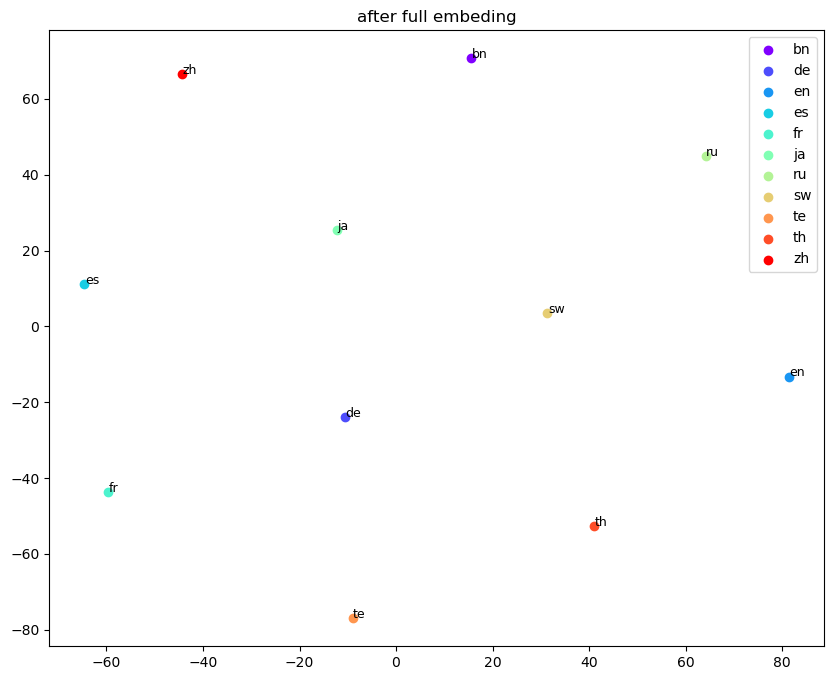